## Customer Churn Prediction
Predict whether a customer is going to churn based on the various usage parameters of the online E-Commerce company

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from statsmodels.graphics.gofplots import qqplot
#from sklearn.feature_selection import RFECV
#from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.preprocessing import StandardScaler


from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm


C:\Users\chith\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data=pd.read_excel('E Commerce Dataset.xlsx',sheet_name='E Comm')
data_eda=data.copy()
data.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [3]:
print(data.Churn.value_counts())
data.Churn.value_counts(normalize=True)

0    4682
1     948
Name: Churn, dtype: int64


0    0.831616
1    0.168384
Name: Churn, dtype: float64

#CC and Credit card gives different churn rate.
#It could be credit card of different bank/company.So I am keeping it as it is for now.
#In next iteration we can try to merge CC

#24% no complain churned

In [4]:
data.PreferredPaymentMode=data.PreferredPaymentMode.str.replace('COD','Cash on Delivery')
data.PreferedOrderCat=data.PreferedOrderCat.str.replace('^Mobile$','Mobile Phone')

data['CityTier'] = data['CityTier'].apply(lambda x: 'Tier-1' if x == 1 else ('Tier-2' if x == 2 else 'Tier-3'))

#Different churn rate for both
data.PreferredLoginDevice=data.PreferredLoginDevice.str.replace('^Phone$','Mobile Phone')

#Check for Churn rate before combining categories. See is there is difference(may be different customers)
data.PreferredPaymentMode=data.PreferredPaymentMode.str.replace('CC','Credit Card')


#Highly satisfied customer, No Complain Churn rate is 7%.
#Not satisfied customer No Complain churn rate =18&, complain -churn rate is 37% two times

In [5]:
#Dropping extreme outliers
data.drop(data[data.NumberOfAddress>15].index,inplace=True)#Drop outliers in original data.
data.NumberOfAddress=np.where(data.NumberOfAddress>10,10,data.NumberOfAddress)

data=data.drop(data[data.Tenure>40].index)

data.drop(data[data.WarehouseToHome>100].index,inplace=True)
#Excluding outliers max value in WarehouseToHome for Tier 3/Tier 1 city is 36. 
#I considered this as wrong data and dropped outliers.

#Less than 1% customers have CouponUsed greater than 9.Since we are not able to distinctively identify churn with Coupon used even for higher values , I replaced CouponUsed >10 with 10.
data.CouponUsed=np.where(data.CouponUsed>10,10,data.CouponUsed)

data.drop(data[data.DaySinceLastOrder>=30].index,inplace=True)

#Less than 1% customers have CouponUsed greater than 9.Since we are not able to distinctively identify churn with Coupon used even for higher values , I replaced CouponUsed >10 with 10.

#can use linear regression to impute order count and Coupon used
#remove order count=0 from model

In [6]:
data.Tenure=data.Tenure.fillna(data.Tenure.median())
data.WarehouseToHome=data.WarehouseToHome.fillna(data.WarehouseToHome.median())
data.HourSpendOnApp=data.HourSpendOnApp.fillna(data.HourSpendOnApp.median())
data.OrderAmountHikeFromlastYear=data.OrderAmountHikeFromlastYear.fillna(data.OrderAmountHikeFromlastYear.median())
data.CouponUsed=data.CouponUsed.fillna(data.CouponUsed.median())
data.OrderCount=data.OrderCount.fillna(data.OrderCount.median())
data.DaySinceLastOrder=data.DaySinceLastOrder.fillna(data.DaySinceLastOrder.median())

Complain is higher for people who churned
Avg tenure is high for customers not churned

75% customers who churned were with us less than 3 months

Churned customers - 53% complains
not much difference in order count distribution & cashback amount


#Single people have higher churn rate

#For Mobile and Mobile Phone Churn rate is also same. so we can combine them, PreferredLoginDevice

#For Phone and Mobile Phone Churn rate is different. Phoen and Mobile phone could be different things. Mobile phone could be high end smart phone and Phone would be basic model/older version key pad phone.

#COD,Cash On Delivery gives different Churn rate. So I am keeping it as it is for now. Similarly CC and Credit card gives different churn rate.It could be credit card of different bank/company.So I am keeping it as it is for now.

#Huge % of people who raised a complain churned.

#more people who churned have satisfaction score 4/5

3 clusters 
Cluster 0 - People who buy Laptop & Accesory and average Tenure 10 months, med
Cluster 1 -People who buy Mobile Phone and average tenure is 6 months
Cluster 2 - People who buy Grocery and Others and average tenure is 20 months. Higher Order Count and High Cashback amount

data['CustomerType']=pd.cut(data.Tenure,[0,6,21,61],labels=['new','mid','loyal'],include_lowest=True)
#Loyal customers - Tenure>21, don't churn

In [7]:
#Hours spend On App - 2 to 4 there is Churn and tenure below 20

#Churned - Day since last order <10 for satisfaction score 1,2,3(1 outlier in Satisfaction Score 3)
# 4 ans 5, less than 15

#Cashback <100 did not churn
#Many Cashback >200 and Complain churned.
#very few with cashback>300 and no complain churned

In [8]:
#82% data coupon used 0,1,2
# 3 & 4 - 10%
#5,6,7, - 5.5%

In [9]:
def cal_performance_metrics(model,X,y):
    y_predict =model.predict(X)   
    
    fig, ax = plt.subplots()
    sns.heatmap(metrics.confusion_matrix(y, y_predict),annot=True, fmt='d', cbar=False,cmap='YlGnBu',
                xticklabels=['Not Churn','Churn'],yticklabels=['Not Churn','Churn'],annot_kws={"size": 20})
    ax.set_ylim([0,2])
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title('Confusion Matrix ',fontsize=20)
    plt.show()
    
    print("Classification report")
    print(metrics.classification_report(y, y_predict))
    
    model_score = model.score(X,y)
    model_score = (model_score*100).round(2)
    print('Accuracy :',model_score,'%')
    cm1 = metrics.confusion_matrix(y,y_predict)
    
    precision=cm1[1,1]/(cm1[1,1]+cm1[0,1]) # Of all 1's predicted, how many were predicted right.
    precision=(precision*100).round(2)
    print('Precision : ',precision,'%') #False positive , alpha Type 1 error
    
    sensitivity1 = cm1[1,1]/(cm1[1,1]+cm1[1,0])
    sensitivity = (sensitivity1*100).round(2)
    print('Recall / True Positive Rate : ',sensitivity,'%') # Sensitivity - How many actual true data points are identified by model
#Type2 Error beta

    specificity1 = cm1[0,0]/(cm1[0,1]+cm1[0,0])
    specificity = (specificity1*100).round(2)
    print('Specificity / True Negative Rate : ',specificity,'%') # How many negative points identified by model
    # samples that test negative using the test in question that are genuinely negative.
    
     # predict probabilities
    probs = model.predict_proba(X)
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # calculate AUC
    auc = metrics.roc_auc_score(y, probs)*100
    print('ROC AUC Score: %.1f' % auc.round(2),'%')
    # calculate roc curve
    train_fpr, train_tpr, train_thresholds = metrics.roc_curve(y, probs)
    fig, ax = plt.subplots()
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the best model
    plt.plot(train_fpr, train_tpr)
    plt.title('ROC Curve ',fontsize=20)
    plt.show()
    return model_score,precision,sensitivity

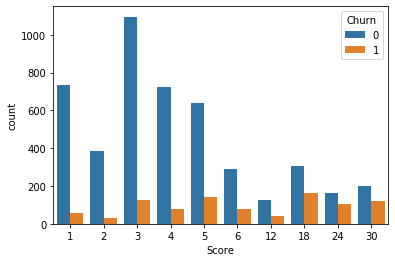

In [10]:
data['Score']=((data['Complain']*5)+1)*data.SatisfactionScore
sns.countplot(data['Score'],hue=data.Churn)

In [11]:
#Try merging CC and Credit Card for new data
data_cc=data.copy()
data_cc.PreferredPaymentMode=data_cc.PreferredPaymentMode.str.replace('CC','Credit Card')

data_cc=pd.get_dummies(data_cc,drop_first=True)

#'HourSpendOnApp','NumberOfDeviceRegistered','OrderAmountHikeFromlastYear' ARE INSIGNIFICANT VARIABLES
X=data_cc.drop(['CustomerID','Churn','HourSpendOnApp','NumberOfDeviceRegistered','OrderAmountHikeFromlastYear'],axis=1)
y=data_cc.Churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25 , random_state=1)
#Merging cc gives slighlty better results for tree based models

In [12]:
X_train.shape,len(y_test)

((4212, 25), 1405)

In [13]:
y_train.value_counts(normalize=True)

0    0.832384
1    0.167616
Name: Churn, dtype: float64

In [14]:
y_test.value_counts(normalize=True)

0    0.829893
1    0.170107
Name: Churn, dtype: float64

In [15]:
std=StandardScaler()
X_train_scaled=pd.DataFrame(std.fit_transform(X_train),columns=X_train.columns)
X_test_scaled=pd.DataFrame(std.transform(X_test),columns=X_train.columns)

### Gaussian Naive Bayes

Train data Performance metrics


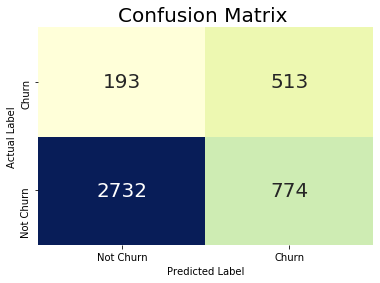

Classification report
              precision    recall  f1-score   support

           0       0.93      0.78      0.85      3506
           1       0.40      0.73      0.51       706

    accuracy                           0.77      4212
   macro avg       0.67      0.75      0.68      4212
weighted avg       0.84      0.77      0.79      4212

Accuracy : 77.04 %
Precision :  39.86 %
Recall / True Positive Rate :  72.66 %
Specificity / True Negative Rate :  77.92 %
ROC AUC Score: 81.8 %


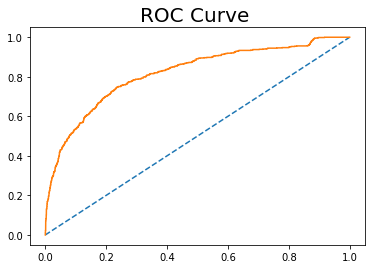

Test data Performance metrics


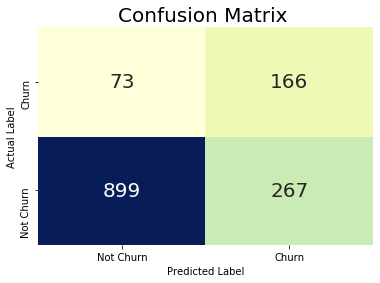

Classification report
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1166
           1       0.38      0.69      0.49       239

    accuracy                           0.76      1405
   macro avg       0.65      0.73      0.67      1405
weighted avg       0.83      0.76      0.78      1405

Accuracy : 75.8 %
Precision :  38.34 %
Recall / True Positive Rate :  69.46 %
Specificity / True Negative Rate :  77.1 %
ROC AUC Score: 80.8 %


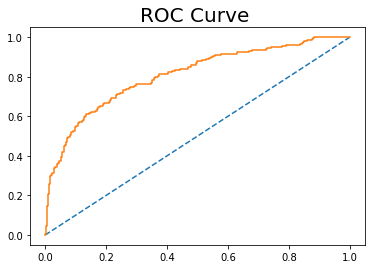

In [16]:
NB_model = GaussianNB()
NB_model.fit(X_train, y_train)
print('Train data Performance metrics')
train_score,train_precision,train_recall=cal_performance_metrics(NB_model,X_train,y_train)
print('Test data Performance metrics')
test_score,test_precision,test_recall=cal_performance_metrics(NB_model,X_test,y_test)
model_accuracyDF=pd.DataFrame({'Train Score':train_score,'Test Score':test_score,'Train Precision':train_precision,'Test Precision':test_precision,'Train Recall':train_recall,'Test Recall':test_recall},index=['Naive Bayes'])

In [17]:
predict_nb=NB_model.predict(X_test)

### SVM

Train data Performance metrics


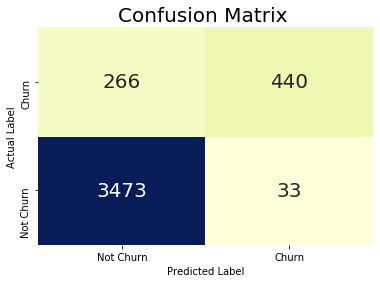

Classification report
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3506
           1       0.93      0.62      0.75       706

    accuracy                           0.93      4212
   macro avg       0.93      0.81      0.85      4212
weighted avg       0.93      0.93      0.92      4212

Accuracy : 92.9 %
Precision :  93.02 %
Recall / True Positive Rate :  62.32 %
Specificity / True Negative Rate :  99.06 %
ROC AUC Score: 96.2 %


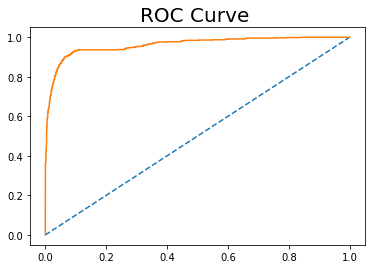

Test data Performance metrics


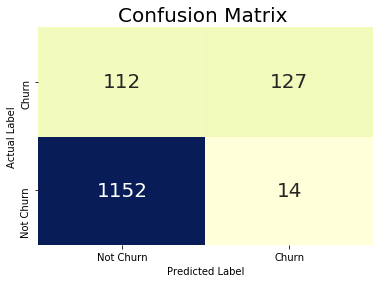

Classification report
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1166
           1       0.90      0.53      0.67       239

    accuracy                           0.91      1405
   macro avg       0.91      0.76      0.81      1405
weighted avg       0.91      0.91      0.90      1405

Accuracy : 91.03 %
Precision :  90.07 %
Recall / True Positive Rate :  53.14 %
Specificity / True Negative Rate :  98.8 %
ROC AUC Score: 93.0 %


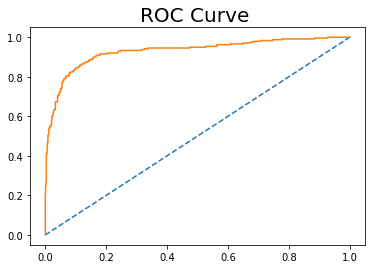

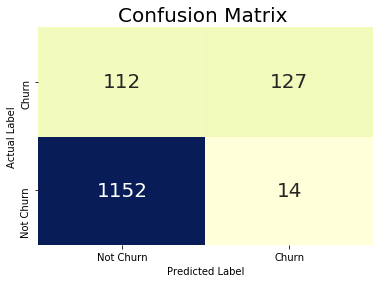

Classification report
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1166
           1       0.90      0.53      0.67       239

    accuracy                           0.91      1405
   macro avg       0.91      0.76      0.81      1405
weighted avg       0.91      0.91      0.90      1405

Accuracy : 91.03 %
Precision :  90.07 %
Recall / True Positive Rate :  53.14 %
Specificity / True Negative Rate :  98.8 %
ROC AUC Score: 93.0 %


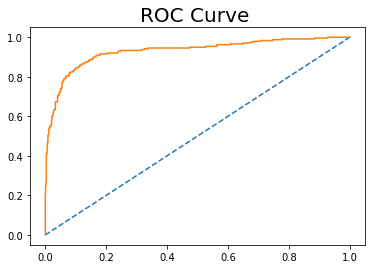

In [18]:
SVM_model= svm.SVC(random_state=1,probability=True)
SVM_model.fit(X_train_scaled, y_train)
print('Train data Performance metrics')
train_score,train_precision,train_recall=cal_performance_metrics(SVM_model,X_train_scaled, y_train)
print('Test data Performance metrics')
test_score,test_precision,test_recall=cal_performance_metrics(SVM_model,X_test_scaled, y_test)
test_score,test_precision,test_recall=cal_performance_metrics(SVM_model,X_test_scaled, y_test)
temp_accuracyDF=pd.DataFrame({'Train Score':train_score,'Test Score':test_score,'Train Precision':train_precision,'Test Precision':test_precision,'Train Recall':train_recall,'Test Recall':test_recall},index=['SVM'])
model_accuracyDF=pd.concat([model_accuracyDF,temp_accuracyDF])

param_grid = {'C':[3.0],  # penalty parameter C of the error term - 1.0,2.0, 3.0 0.25,0.5,0.75, 
              'gamma':[0.08] # kernel coefficient for 'rbf',0.02,0.05,0.08,0.1,0.15,0.2
             }
grid_search = GridSearchCV(estimator = svm.SVC(), param_grid = param_grid, cv = 3,verbose=True,n_jobs=-1,scoring=['precision','recall'],refit=False)
grid_search.fit(X_train_scaled, y_train)

Train data Performance metrics


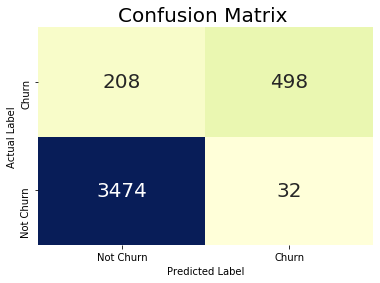

Classification report
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      3506
           1       0.94      0.71      0.81       706

    accuracy                           0.94      4212
   macro avg       0.94      0.85      0.89      4212
weighted avg       0.94      0.94      0.94      4212

Accuracy : 94.3 %
Precision :  93.96 %
Recall / True Positive Rate :  70.54 %
Specificity / True Negative Rate :  99.09 %
ROC AUC Score: 97.2 %


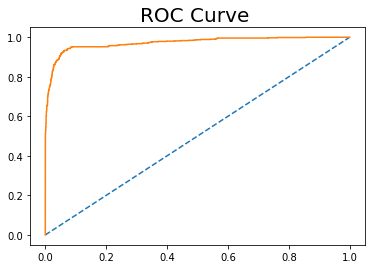

Test data Performance metrics


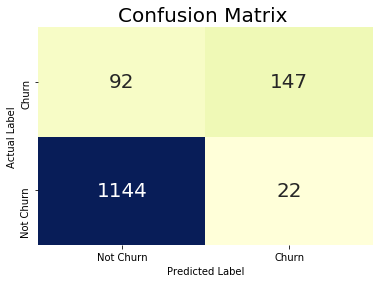

Classification report
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1166
           1       0.87      0.62      0.72       239

    accuracy                           0.92      1405
   macro avg       0.90      0.80      0.84      1405
weighted avg       0.92      0.92      0.91      1405

Accuracy : 91.89 %
Precision :  86.98 %
Recall / True Positive Rate :  61.51 %
Specificity / True Negative Rate :  98.11 %
ROC AUC Score: 93.5 %


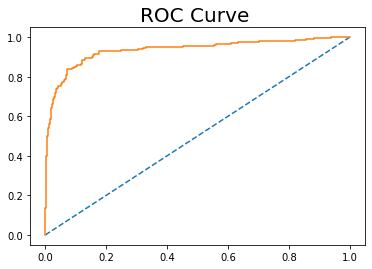

In [19]:
SVM_model= svm.SVC(random_state=1,C=3.0,gamma=0.03,probability=True)
SVM_model.fit(X_train_scaled, y_train)
print('Train data Performance metrics')
train_score,train_precision,train_recall=cal_performance_metrics(SVM_model,X_train_scaled, y_train)
print('Test data Performance metrics')
test_score,test_precision,test_recall=cal_performance_metrics(SVM_model,X_test_scaled, y_test)
temp_accuracyDF=pd.DataFrame({'Train Score':train_score,'Test Score':test_score,'Train Precision':train_precision,'Test Precision':test_precision,'Train Recall':train_recall,'Test Recall':test_recall},index=['SVM_Tuned'])
model_accuracyDF=pd.concat([model_accuracyDF,temp_accuracyDF])

In [20]:
model_accuracyDF

,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
Naive Bayes,77.04,75.80,39.86,38.34,72.66,69.46
SVM,92.90,91.03,93.02,90.07,62.32,53.14
SVM_Tuned,94.30,91.89,93.96,86.98,70.54,61.51


### Neural Network

Train data Performance metrics


C:\Users\chith\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


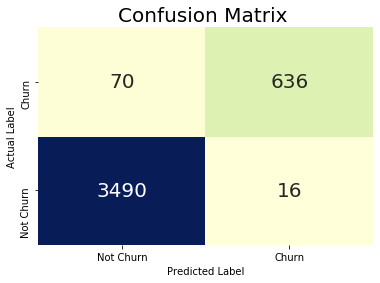

Classification report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3506
           1       0.98      0.90      0.94       706

    accuracy                           0.98      4212
   macro avg       0.98      0.95      0.96      4212
weighted avg       0.98      0.98      0.98      4212

Accuracy : 97.96 %
Precision :  97.55 %
Recall / True Positive Rate :  90.08 %
Specificity / True Negative Rate :  99.54 %
ROC AUC Score: 99.8 %


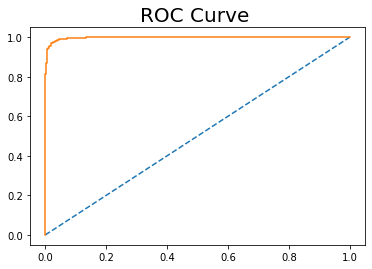

Test data Performance metrics


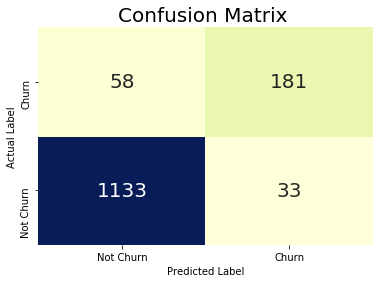

Classification report
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1166
           1       0.85      0.76      0.80       239

    accuracy                           0.94      1405
   macro avg       0.90      0.86      0.88      1405
weighted avg       0.93      0.94      0.93      1405

Accuracy : 93.52 %
Precision :  84.58 %
Recall / True Positive Rate :  75.73 %
Specificity / True Negative Rate :  97.17 %
ROC AUC Score: 96.7 %


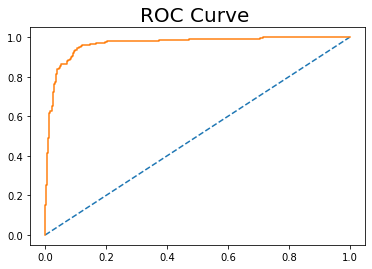

In [21]:
mlp=MLPClassifier()
mlp.fit(X_train_scaled, y_train)
print('Train data Performance metrics')
train_score,train_precision,train_recall=cal_performance_metrics(mlp,X_train_scaled, y_train)
print('Test data Performance metrics')
test_score,test_precision,test_recall=cal_performance_metrics(mlp,X_test_scaled, y_test)
temp_accuracyDF=pd.DataFrame({'Train Score':train_score,'Test Score':test_score,'Train Precision':train_precision,'Test Precision':test_precision,'Train Recall':train_recall,'Test Recall':test_recall},index=['MLP'])
model_accuracyDF=pd.concat([model_accuracyDF,temp_accuracyDF])

param_grid = {
    'hidden_layer_sizes': [(100,10,10),(100,100),(200,100)], #,,(100,100,10),50,200,100,,(100,50,10)
    'max_iter': [3000], #2000,7000,5000,4000
    'solver': ['adam'], #sgd
}
nncl = MLPClassifier()

grid_search = GridSearchCV(estimator = nncl, param_grid = param_grid, cv = 3,verbose=True,n_jobs=-1,scoring=['precision','recall'],refit=False)

grid_search.fit(X_train_scaled, y_train)
grid_search.cv_results_

Train data Performance metrics


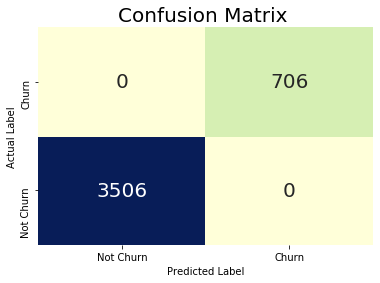

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3506
           1       1.00      1.00      1.00       706

    accuracy                           1.00      4212
   macro avg       1.00      1.00      1.00      4212
weighted avg       1.00      1.00      1.00      4212

Accuracy : 100.0 %
Precision :  100.0 %
Recall / True Positive Rate :  100.0 %
Specificity / True Negative Rate :  100.0 %
ROC AUC Score: 100.0 %


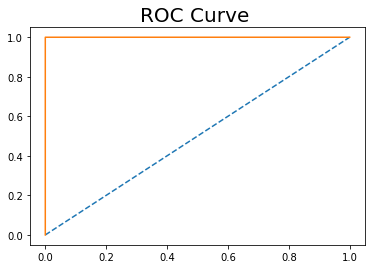

Test data Performance metrics


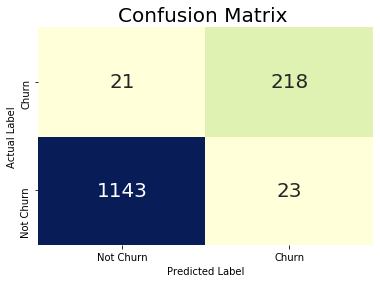

Classification report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1166
           1       0.90      0.91      0.91       239

    accuracy                           0.97      1405
   macro avg       0.94      0.95      0.94      1405
weighted avg       0.97      0.97      0.97      1405

Accuracy : 96.87 %
Precision :  90.46 %
Recall / True Positive Rate :  91.21 %
Specificity / True Negative Rate :  98.03 %
ROC AUC Score: 98.7 %


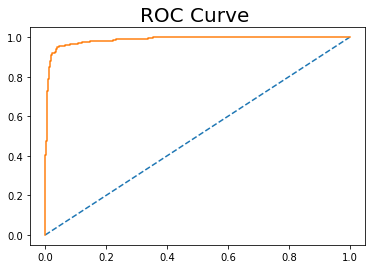

In [22]:
X_mlp=X_train_scaled.drop('CouponUsed',axis=1)
X_test_mlp=X_test_scaled.drop('CouponUsed',axis=1)
mlp=MLPClassifier(hidden_layer_sizes=(100,100),solver='adam')
mlp.fit(X_mlp,y_train)
print('Train data Performance metrics')
train_score,train_precision,train_recall=cal_performance_metrics(mlp,X_mlp, y_train)
print('Test data Performance metrics')
test_score,test_precision,test_recall=cal_performance_metrics(mlp,X_test_mlp, y_test)

temp_accuracyDF=pd.DataFrame({'Train Score':train_score,'Test Score':test_score,'Train Precision':train_precision,'Test Precision':test_precision,'Train Recall':train_recall,'Test Recall':test_recall},index=['MLP Tuned 2'])
model_accuracyDF=pd.concat([model_accuracyDF,temp_accuracyDF])
predict_mlp1=mlp.predict(X_test_mlp)
#100% train in test accuracy 97.3 precision - 95, recall 89

In [23]:
X_train.columns

Index(['Tenure', 'WarehouseToHome', 'SatisfactionScore', 'NumberOfAddress',
       'Complain', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder',
       'CashbackAmount', 'Score', 'PreferredLoginDevice_Mobile Phone',
       'PreferredLoginDevice_Phone', 'CityTier_Tier-2', 'CityTier_Tier-3',
       'PreferredPaymentMode_Credit Card', 'PreferredPaymentMode_Debit Card',
       'PreferredPaymentMode_E wallet', 'PreferredPaymentMode_UPI',
       'Gender_Male', 'PreferedOrderCat_Grocery',
       'PreferedOrderCat_Laptop & Accessory', 'PreferedOrderCat_Mobile Phone',
       'PreferedOrderCat_Others', 'MaritalStatus_Married',
       'MaritalStatus_Single'],
      dtype='object')

Train data Performance metrics


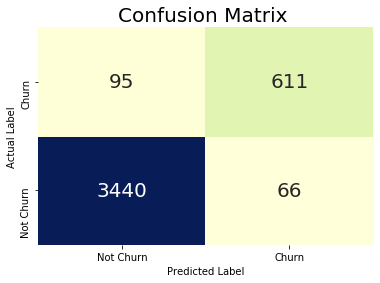

Classification report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3506
           1       0.90      0.87      0.88       706

    accuracy                           0.96      4212
   macro avg       0.94      0.92      0.93      4212
weighted avg       0.96      0.96      0.96      4212

Accuracy : 96.18 %
Precision :  90.25 %
Recall / True Positive Rate :  86.54 %
Specificity / True Negative Rate :  98.12 %
ROC AUC Score: 99.1 %


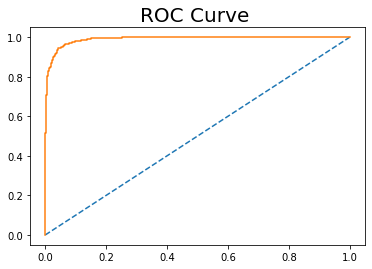

Test data Performance metrics


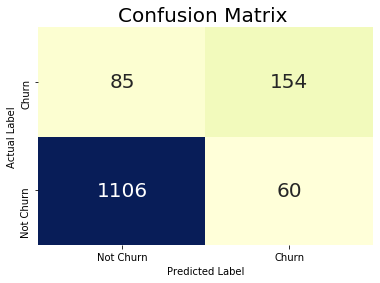

Classification report
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1166
           1       0.72      0.64      0.68       239

    accuracy                           0.90      1405
   macro avg       0.82      0.80      0.81      1405
weighted avg       0.89      0.90      0.89      1405

Accuracy : 89.68 %
Precision :  71.96 %
Recall / True Positive Rate :  64.44 %
Specificity / True Negative Rate :  94.85 %
ROC AUC Score: 93.4 %


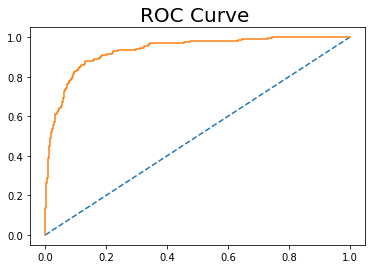

In [24]:
mlp_feat=['Tenure',   'SatisfactionScore','Complain', 'CouponUsed',# 'DaySinceLastOrder', 
          'CashbackAmount','PreferredLoginDevice_Mobile Phone', 'PreferredLoginDevice_Phone',
       #'CityTier_Tier-2', 'CityTier_Tier-3',
       'PreferredPaymentMode_Credit Card', 'PreferredPaymentMode_Debit Card',
       'PreferredPaymentMode_E wallet', 'PreferredPaymentMode_UPI',
   'PreferedOrderCat_Grocery','PreferedOrderCat_Laptop & Accessory', 'PreferedOrderCat_Mobile Phone','PreferedOrderCat_Others',
        'MaritalStatus_Married', 'Gender_Male','MaritalStatus_Single']
mlp=MLPClassifier(hidden_layer_sizes=(100,100,10),solver='sgd',max_iter=3000,random_state=1,activation='tanh')
mlp.fit(X_train_scaled[mlp_feat],y_train)
print('Train data Performance metrics')
train_score,train_precision,train_recall=cal_performance_metrics(mlp,X_train_scaled[mlp_feat], y_train)
print('Test data Performance metrics')
test_score,test_precision,test_recall=cal_performance_metrics(mlp,X_test_scaled[mlp_feat], y_test)
temp_accuracyDF=pd.DataFrame({'Train Score':train_score,'Test Score':test_score,'Train Precision':train_precision,'Test Precision':test_precision,'Train Recall':train_recall,'Test Recall':test_recall},index=['MLPf3'])
model_accuracyDF=pd.concat([model_accuracyDF,temp_accuracyDF])

In [25]:
model_accuracyDF

,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
Naive Bayes,77.04,75.80,39.86,38.34,72.66,69.46
SVM,92.90,91.03,93.02,90.07,62.32,53.14
SVM_Tuned,94.30,91.89,93.96,86.98,70.54,61.51
MLP,97.96,93.52,97.55,84.58,90.08,75.73
MLP Tuned 2,100.00,96.87,100.00,90.46,100.00,91.21
MLPf3,96.18,89.68,90.25,71.96,86.54,64.44


#LIght GBM,CatBoost
Try algorith,Plot,tune

### Linear Discriminant Analysis

Train data Performance metrics


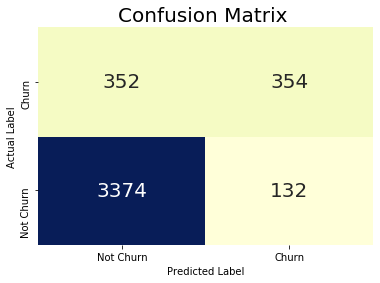

Classification report
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      3506
           1       0.73      0.50      0.59       706

    accuracy                           0.89      4212
   macro avg       0.82      0.73      0.76      4212
weighted avg       0.88      0.89      0.88      4212

Accuracy : 88.51 %
Precision :  72.84 %
Recall / True Positive Rate :  50.14 %
Specificity / True Negative Rate :  96.24 %
ROC AUC Score: 88.9 %


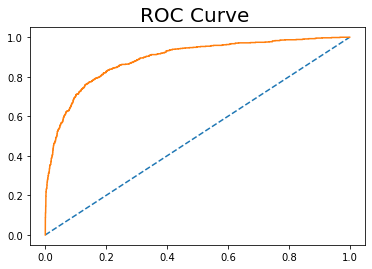

Test data Performance metrics


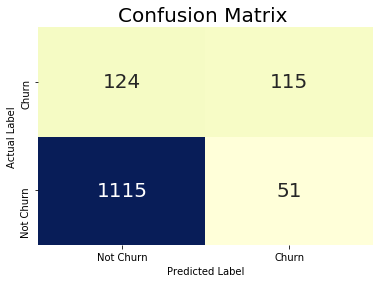

Classification report
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1166
           1       0.69      0.48      0.57       239

    accuracy                           0.88      1405
   macro avg       0.80      0.72      0.75      1405
weighted avg       0.86      0.88      0.87      1405

Accuracy : 87.54 %
Precision :  69.28 %
Recall / True Positive Rate :  48.12 %
Specificity / True Negative Rate :  95.63 %
ROC AUC Score: 86.7 %


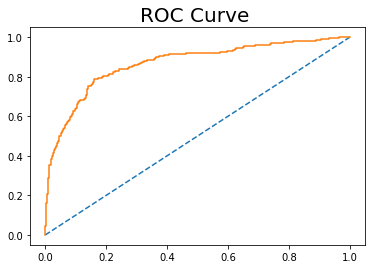

In [26]:
#Basic LDA model
LDA_model= LinearDiscriminantAnalysis()
LDA_model.fit(X_train, y_train)
print('Train data Performance metrics')
train_score,train_precision,train_recall=cal_performance_metrics(LDA_model,X_train,y_train)
print('Test data Performance metrics')
test_score,test_precision,test_recall=cal_performance_metrics(LDA_model,X_test,y_test)
temp_accuracyDF=pd.DataFrame({'Train Score':train_score,'Test Score':test_score,'Train Precision':train_precision,'Test Precision':test_precision,'Train Recall':train_recall,'Test Recall':test_recall},index=['LDA'])
model_accuracyDF=pd.concat([model_accuracyDF,temp_accuracyDF])

In [27]:
#All LDA solver algorithm show similar result
#accuracy score is same for eigen,lsqr and svd. I am taking default parameters.

#### Log transformation

In [28]:
cont=['Tenure',
 'WarehouseToHome',
# 'HourSpendOnApp',
 #'NumberOfDeviceRegistered',
 'NumberOfAddress',
 #'OrderAmountHikeFromlastYear',
 'CouponUsed',
 'OrderCount',
 'DaySinceLastOrder',
 'CashbackAmount']
cat=['CityTier_Tier-2', 'CityTier_Tier-3','SatisfactionScore','Complain','PreferredLoginDevice_Mobile Phone',
       'PreferredLoginDevice_Phone', 
       'PreferredPaymentMode_Credit Card', 'PreferredPaymentMode_Debit Card',
       'PreferredPaymentMode_E wallet', 'PreferredPaymentMode_UPI',
       'Gender_Male', 'PreferedOrderCat_Grocery','PreferedOrderCat_Laptop & Accessory', 'PreferedOrderCat_Mobile Phone',
       'PreferedOrderCat_Others', 'MaritalStatus_Married','MaritalStatus_Single']
data_LDA=data_cc.copy()

In [29]:
data_LDA_log=data_LDA[cont].copy()
print('Before imputation\n',data_LDA_log[data_LDA_log[cont]==0][cont].notnull().sum())
data_LDA_log['Tenure']=data_LDA_log['Tenure'].replace(0,1)
data_LDA_log['DaySinceLastOrder']=data_LDA_log['DaySinceLastOrder'].replace(0,1)
data_LDA_log['CashbackAmount']=data_LDA_log['CashbackAmount'].replace(0,1)
data_LDA_log['CouponUsed']=data_LDA_log['CouponUsed'].replace(0,0.1)
#data_LDA_log['HourSpendOnApp']=data_LDA_log['HourSpendOnApp'].replace(0,0.1)
#data_LDA_log['NumberOfDeviceRegistered']=data_LDA_log['NumberOfDeviceRegistered'].replace(0,0.1)
data_LDA_log['NumberOfAddress']=data_LDA_log['NumberOfAddress'].replace(0,0.1)
data_LDA_log['OrderCount']=data_LDA_log['OrderCount'].replace(0,0.1)
print('\nAfter imputation\n',data_LDA_log[data_LDA_log[cont]==0][cont].notnull().sum())
data_LDA_log=np.log(data_LDA_log)

Before imputation
 Tenure                507
WarehouseToHome         0
NumberOfAddress         0
CouponUsed           1029
OrderCount              0
DaySinceLastOrder     493
CashbackAmount          4
dtype: int64

After imputation
 Tenure               0
WarehouseToHome      0
NumberOfAddress      0
CouponUsed           0
OrderCount           0
DaySinceLastOrder    0
CashbackAmount       0
dtype: int64



data_LDA_log['Churn']=data_LDA['Churn']
fig,ax=plt.subplots(nrows=10)
fig.set_size_inches(10,20)
for i,var in enumerate(cont):
    data_LDA_log.groupby('Churn')[var].plot(kind='kde',ax=ax[i])
    plt.title(var)

fig,ax=plt.subplots(nrows=10)
fig.set_size_inches(10,20)
for i,var in enumerate(cont):
    qqplot(data_LDA_log[var],line='s',ax=ax[i])

In [30]:
data_LDA_log=pd.concat([data_LDA_log,data_LDA[cat]],axis=1)
X_log_train,X_log_test,y_log_train,y_log_test=train_test_split(data_LDA_log, y, test_size=0.25 , random_state=1)

Train data Performance metrics


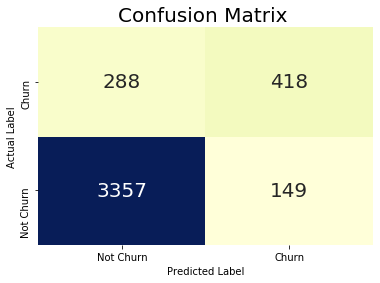

Classification report
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3506
           1       0.74      0.59      0.66       706

    accuracy                           0.90      4212
   macro avg       0.83      0.77      0.80      4212
weighted avg       0.89      0.90      0.89      4212

Accuracy : 89.62 %
Precision :  73.72 %
Recall / True Positive Rate :  59.21 %
Specificity / True Negative Rate :  95.75 %
ROC AUC Score: 89.5 %


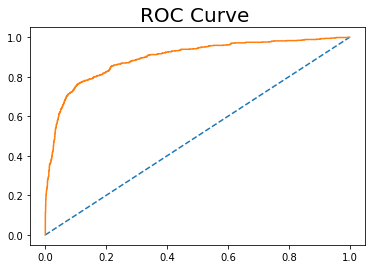

Test data Performance metrics


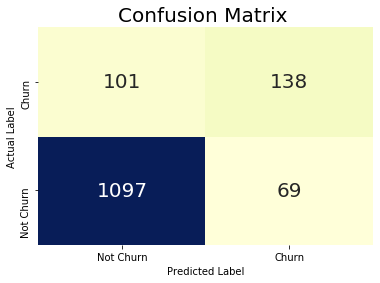

Classification report
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1166
           1       0.67      0.58      0.62       239

    accuracy                           0.88      1405
   macro avg       0.79      0.76      0.77      1405
weighted avg       0.87      0.88      0.88      1405

Accuracy : 87.9 %
Precision :  66.67 %
Recall / True Positive Rate :  57.74 %
Specificity / True Negative Rate :  94.08 %
ROC AUC Score: 87.5 %


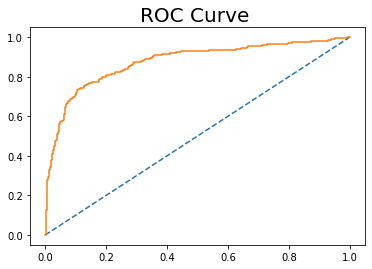

In [31]:
LDA_model_log= LinearDiscriminantAnalysis()
LDA_model_log.fit(X_log_train, y_log_train)
print('Train data Performance metrics')
train_score,train_precision,train_recall=cal_performance_metrics(LDA_model_log,X_log_train, y_log_train)
print('Test data Performance metrics')
test_score,test_precision,test_recall=cal_performance_metrics(LDA_model_log,X_log_test, y_log_test)
temp_accuracyDF=pd.DataFrame({'Train Score':train_score,'Test Score':test_score,'Train Precision':train_precision,'Test Precision':test_precision,'Train Recall':train_recall,'Test Recall':test_recall},index=['LDA Log Transformed'])
model_accuracyDF=pd.concat([model_accuracyDF,temp_accuracyDF])

### Gradient Boosting

Train data Performance metrics


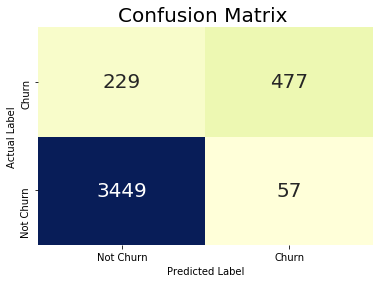

Classification report
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3506
           1       0.89      0.68      0.77       706

    accuracy                           0.93      4212
   macro avg       0.92      0.83      0.86      4212
weighted avg       0.93      0.93      0.93      4212

Accuracy : 93.21 %
Precision :  89.33 %
Recall / True Positive Rate :  67.56 %
Specificity / True Negative Rate :  98.37 %
ROC AUC Score: 96.3 %


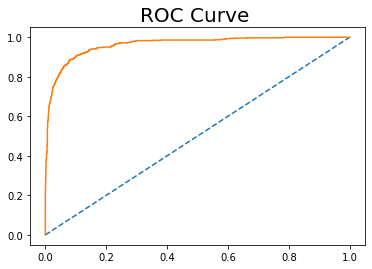

Test data Performance metrics


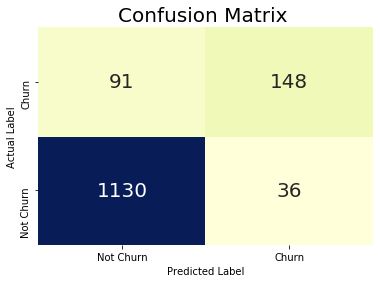

Classification report
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1166
           1       0.80      0.62      0.70       239

    accuracy                           0.91      1405
   macro avg       0.86      0.79      0.82      1405
weighted avg       0.90      0.91      0.90      1405

Accuracy : 90.96 %
Precision :  80.43 %
Recall / True Positive Rate :  61.92 %
Specificity / True Negative Rate :  96.91 %
ROC AUC Score: 93.4 %


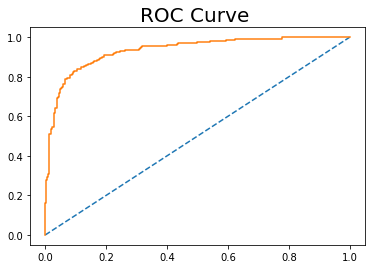

In [32]:
GB_model=GradientBoostingClassifier()
GB_model.fit(X_train,y_train)
print('Train data Performance metrics')
train_score,train_precision,train_recall=cal_performance_metrics(GB_model,X_train,y_train)
print('Test data Performance metrics')
test_score,test_precision,test_recall=cal_performance_metrics(GB_model,X_test,y_test)
temp_accuracyDF=pd.DataFrame({'Train Score':train_score,'Test Score':test_score,'Train Precision':train_precision,'Test Precision':test_precision,'Train Recall':train_recall,'Test Recall':test_recall},index=['Gradient Boosting'])
model_accuracyDF=pd.concat([model_accuracyDF,temp_accuracyDF])

In [33]:
#Merge CC and Credit Card
#Many in Tier 3 cities are using e wallets

In [34]:
param_grid_GB={'n_estimators' : [500,300],#100,200,300,400,
               'min_samples_split' : [30,80], #40,50,60,80,100 #between 0.5 to 1% (2%?)
               'min_samples_leaf' : [5,10],#5,20,25
               'max_depth' : [5],#1,2,3,4
               'learning_rate' : [0.1],#0.01,0.1,1
               'subsample':[0.8]
               }
grid_search=GridSearchCV(GradientBoostingClassifier(learning_rate=0.1,max_features='sqrt'),param_grid=param_grid_GB,n_jobs=-1,cv=3,verbose=True,scoring='precision')
grid_search.fit(X_train, y_train)
#min_sample_leaf =10,min_sample_split=30

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   14.9s finished


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(max_features='sqrt'),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'max_depth': [5],
                         'min_samples_leaf': [5, 10],
                         'min_samples_split': [30, 80],
                         'n_estimators': [500, 300], 'subsample': [0.8]},
             scoring='precision', verbose=True)

Train data Performance metrics


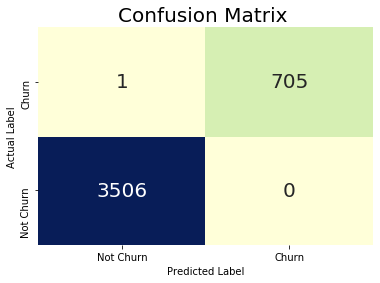

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3506
           1       1.00      1.00      1.00       706

    accuracy                           1.00      4212
   macro avg       1.00      1.00      1.00      4212
weighted avg       1.00      1.00      1.00      4212

Accuracy : 99.98 %
Precision :  100.0 %
Recall / True Positive Rate :  99.86 %
Specificity / True Negative Rate :  100.0 %
ROC AUC Score: 100.0 %


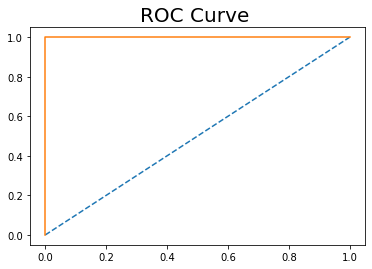

Test data Performance metrics


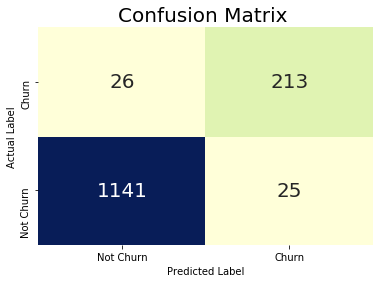

Classification report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1166
           1       0.89      0.89      0.89       239

    accuracy                           0.96      1405
   macro avg       0.94      0.93      0.94      1405
weighted avg       0.96      0.96      0.96      1405

Accuracy : 96.37 %
Precision :  89.5 %
Recall / True Positive Rate :  89.12 %
Specificity / True Negative Rate :  97.86 %
ROC AUC Score: 98.4 %


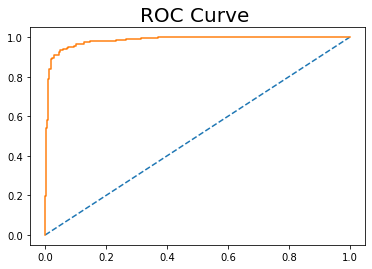

In [35]:
best_GB=grid_search.best_estimator_

print('Train data Performance metrics')
train_score,train_precision,train_recall=cal_performance_metrics(best_GB,X_train, y_train)
print('Test data Performance metrics')
test_score,test_precision,test_recall=cal_performance_metrics(best_GB,X_test,y_test)
#Overfiting

Train data Performance metrics


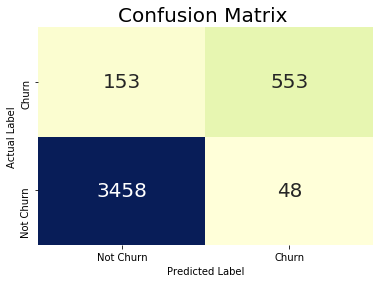

Classification report
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3506
           1       0.92      0.78      0.85       706

    accuracy                           0.95      4212
   macro avg       0.94      0.88      0.91      4212
weighted avg       0.95      0.95      0.95      4212

Accuracy : 95.23 %
Precision :  92.01 %
Recall / True Positive Rate :  78.33 %
Specificity / True Negative Rate :  98.63 %
ROC AUC Score: 98.2 %


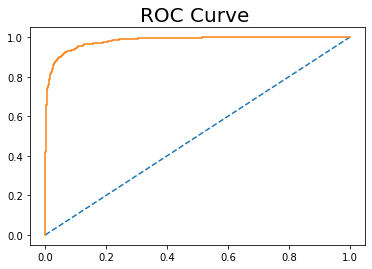

Test data Performance metrics


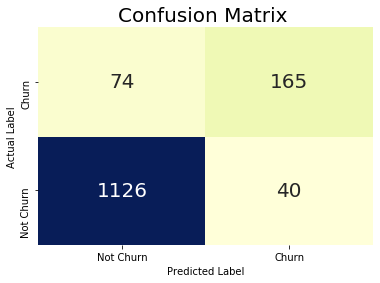

Classification report
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1166
           1       0.80      0.69      0.74       239

    accuracy                           0.92      1405
   macro avg       0.87      0.83      0.85      1405
weighted avg       0.92      0.92      0.92      1405

Accuracy : 91.89 %
Precision :  80.49 %
Recall / True Positive Rate :  69.04 %
Specificity / True Negative Rate :  96.57 %
ROC AUC Score: 94.7 %


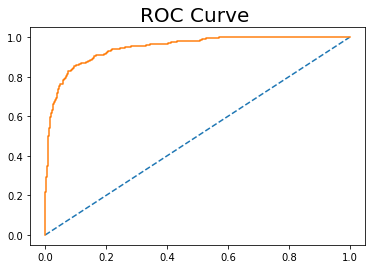

In [36]:
gb_model2=GradientBoostingClassifier(learning_rate=0.1,max_features='sqrt',n_estimators=300,min_samples_split=20,min_samples_leaf=5,max_depth=3,subsample=0.8)
gb_model2.fit(X_train, y_train)
print('Train data Performance metrics')
train_score,train_precision,train_recall=cal_performance_metrics(gb_model2,X_train,y_train)
print('Test data Performance metrics')
test_score,test_precision,test_recall=cal_performance_metrics(gb_model2,X_test,y_test)
temp_accuracyDF=pd.DataFrame({'Train Score':train_score,'Test Score':test_score,'Train Precision':train_precision,'Test Precision':test_precision,'Train Recall':train_recall,'Test Recall':test_recall},index=['Gradient Boosting Tuned'])
model_accuracyDF=pd.concat([model_accuracyDF,temp_accuracyDF])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

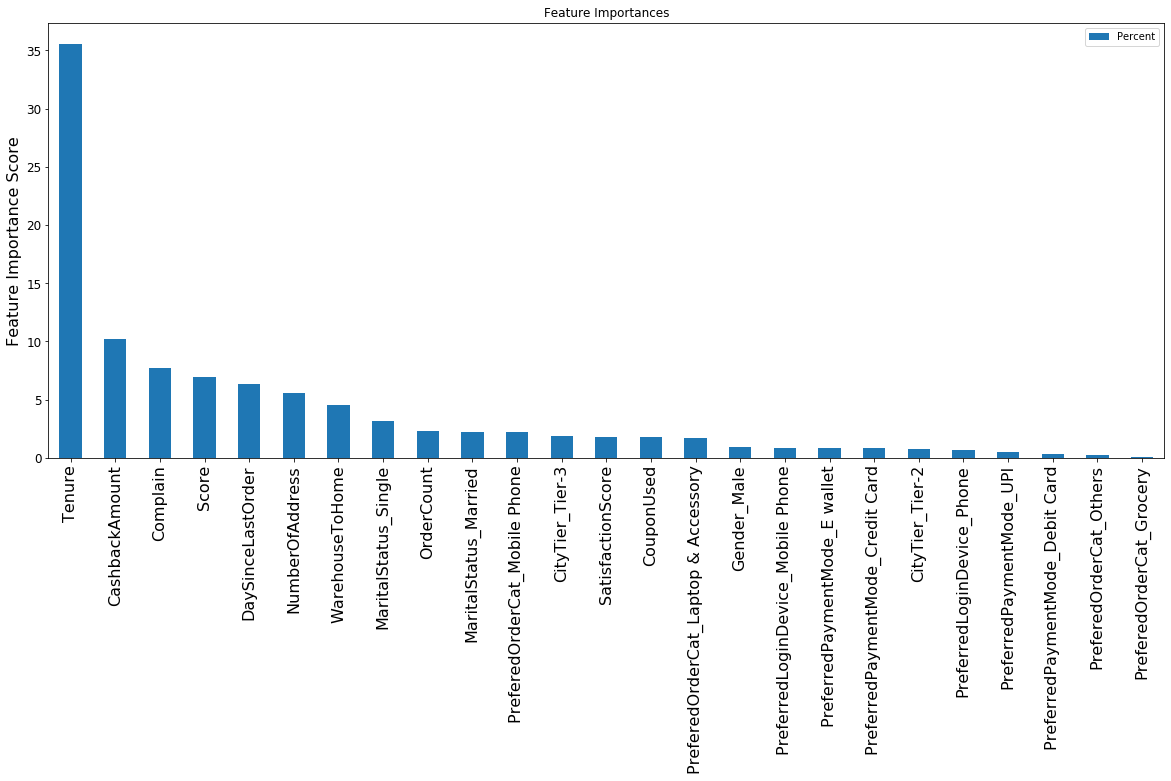

In [37]:
feature_importance=pd.DataFrame((gb_model2.feature_importances_*100).round(2),index=X_train.columns,columns=['Percent']).sort_values('Percent',ascending=False)
feature_importance.plot(kind='bar', title='Feature Importances',figsize=(20,8),fontsize=12)
plt.ylabel('Feature Importance Score',fontsize=16)
plt.xticks(fontsize=16)

feature_importance

In [38]:
#Best Gradient Boosting algorithm

### Adaboost Classifier

Train data Performance metrics


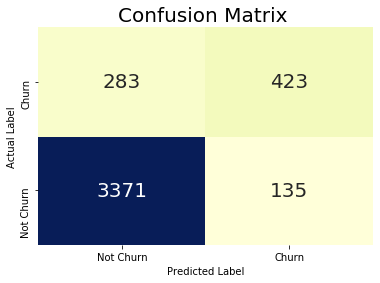

Classification report
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3506
           1       0.76      0.60      0.67       706

    accuracy                           0.90      4212
   macro avg       0.84      0.78      0.81      4212
weighted avg       0.89      0.90      0.90      4212

Accuracy : 90.08 %
Precision :  75.81 %
Recall / True Positive Rate :  59.92 %
Specificity / True Negative Rate :  96.15 %
ROC AUC Score: 93.8 %


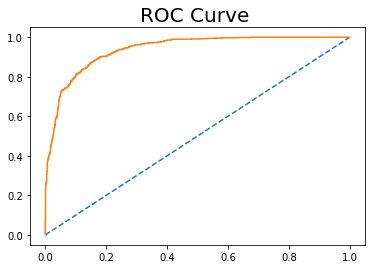

Test data Performance metrics


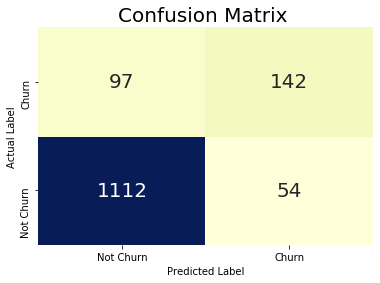

Classification report
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1166
           1       0.72      0.59      0.65       239

    accuracy                           0.89      1405
   macro avg       0.82      0.77      0.79      1405
weighted avg       0.89      0.89      0.89      1405

Accuracy : 89.25 %
Precision :  72.45 %
Recall / True Positive Rate :  59.41 %
Specificity / True Negative Rate :  95.37 %
ROC AUC Score: 91.1 %


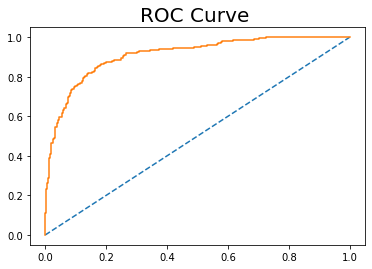

In [39]:
ADB_model = AdaBoostClassifier(n_estimators=100,random_state=1)
ADB_model.fit(X_train,y_train)
print('Train data Performance metrics')
train_score,train_precision,train_recall=cal_performance_metrics(ADB_model,X_train,y_train)
print('Test data Performance metrics')
test_score,test_precision,test_recall=cal_performance_metrics(ADB_model,X_test,y_test)
temp_accuracyDF=pd.DataFrame({'Train Score':train_score,'Test Score':test_score,'Train Precision':train_precision,'Test Precision':test_precision,'Train Recall':train_recall,'Test Recall':test_recall},index=['AdaBoost'])
model_accuracyDF=pd.concat([model_accuracyDF,temp_accuracyDF])

grid = { 'n_estimators' : [75,200],#try 100
               'learning_rate':[0.05,0.01]
             }

grid_search = GridSearchCV(estimator = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4)),scoring=['precision','recall'],
                                                          param_grid = grid, cv = 3,verbose=True,n_jobs=-1,refit=False)
grid_search.fit(X_train, y_train)
grid_search.cv_results_

Train data Performance metrics


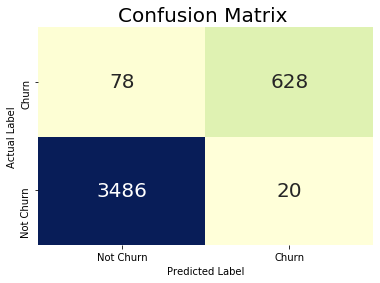

Classification report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3506
           1       0.97      0.89      0.93       706

    accuracy                           0.98      4212
   macro avg       0.97      0.94      0.96      4212
weighted avg       0.98      0.98      0.98      4212

Accuracy : 97.67 %
Precision :  96.91 %
Recall / True Positive Rate :  88.95 %
Specificity / True Negative Rate :  99.43 %
ROC AUC Score: 99.8 %


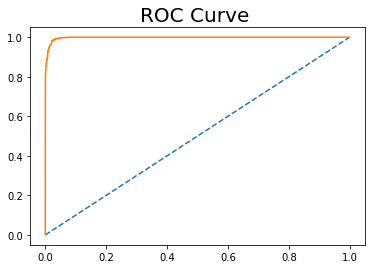

Test data Performance metrics


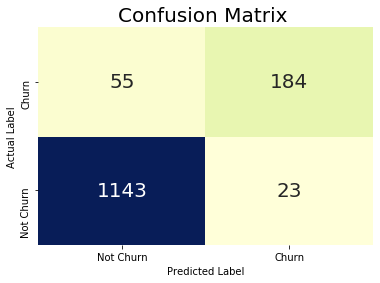

Classification report
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1166
           1       0.89      0.77      0.83       239

    accuracy                           0.94      1405
   macro avg       0.92      0.88      0.90      1405
weighted avg       0.94      0.94      0.94      1405

Accuracy : 94.45 %
Precision :  88.89 %
Recall / True Positive Rate :  76.99 %
Specificity / True Negative Rate :  98.03 %
ROC AUC Score: 96.9 %


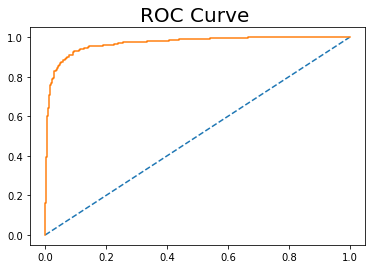

In [40]:
best_model=AdaBoostClassifier(DecisionTreeClassifier(max_depth=4),learning_rate=0.05,n_estimators=200)
best_model.fit(X_train,y_train)
print('Train data Performance metrics')
train_score,train_precision,train_recall=cal_performance_metrics(best_model,X_train,y_train)
print('Test data Performance metrics')
test_score,test_precision,test_recall=cal_performance_metrics(best_model,X_test,y_test)
temp_accuracyDF=pd.DataFrame({'Train Score':train_score,'Test Score':test_score,'Train Precision':train_precision,'Test Precision':test_precision,'Train Recall':train_recall,'Test Recall':test_recall},index=['AdaBoost Tuned'])
model_accuracyDF=pd.concat([model_accuracyDF,temp_accuracyDF])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

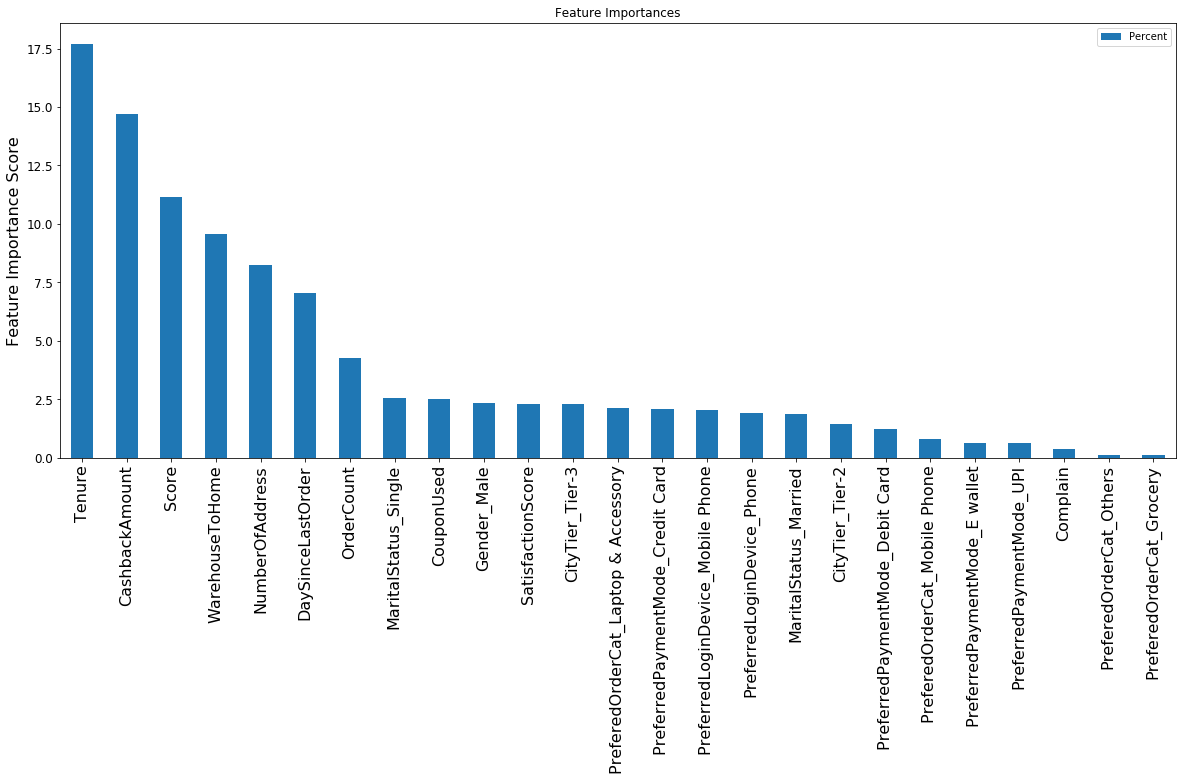

In [41]:
feature_importance=pd.DataFrame((best_model.feature_importances_*100).round(2),index=X_train.columns,columns=['Percent']).sort_values('Percent',ascending=False)
feature_importance.plot(kind='bar', title='Feature Importances',figsize=(20,8),fontsize=12)
plt.ylabel('Feature Importance Score',fontsize=16)
plt.xticks(fontsize=16)

feature_importance

### XGBoost

Train data Performance metrics


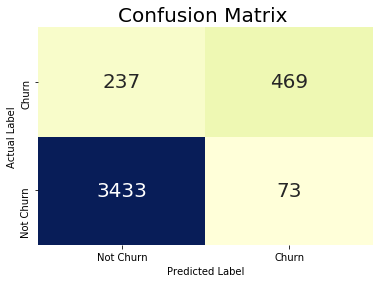

Classification report
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3506
           1       0.87      0.66      0.75       706

    accuracy                           0.93      4212
   macro avg       0.90      0.82      0.85      4212
weighted avg       0.92      0.93      0.92      4212

Accuracy : 92.64 %
Precision :  86.53 %
Recall / True Positive Rate :  66.43 %
Specificity / True Negative Rate :  97.92 %
ROC AUC Score: 95.8 %


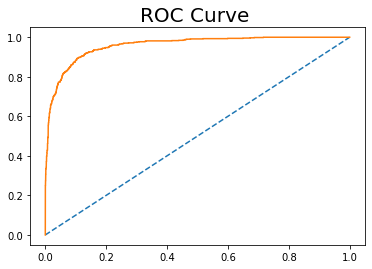

Test data Performance metrics


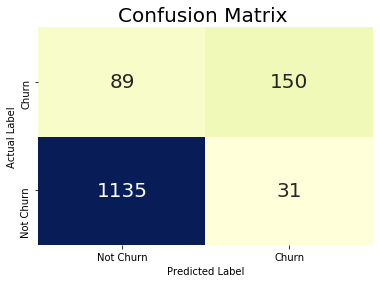

Classification report
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1166
           1       0.83      0.63      0.71       239

    accuracy                           0.91      1405
   macro avg       0.88      0.80      0.83      1405
weighted avg       0.91      0.91      0.91      1405

Accuracy : 91.46 %
Precision :  82.87 %
Recall / True Positive Rate :  62.76 %
Specificity / True Negative Rate :  97.34 %
ROC AUC Score: 93.0 %


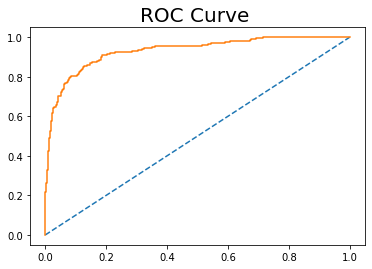

In [42]:
XGB_model=xgb.XGBClassifier(random_state=1)
XGB_model.fit(X_train, y_train)
print('Train data Performance metrics')
train_score,train_precision,train_recall=cal_performance_metrics(XGB_model,X_train,y_train)
print('Test data Performance metrics')
test_score,test_precision,test_recall=cal_performance_metrics(XGB_model,X_test,y_test)
temp_accuracyDF=pd.DataFrame({'Train Score':train_score,'Test Score':test_score,'Train Precision':train_precision,'Test Precision':test_precision,'Train Recall':train_recall,'Test Recall':test_recall},index=['XGBoost'])
model_accuracyDF=pd.concat([model_accuracyDF,temp_accuracyDF])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

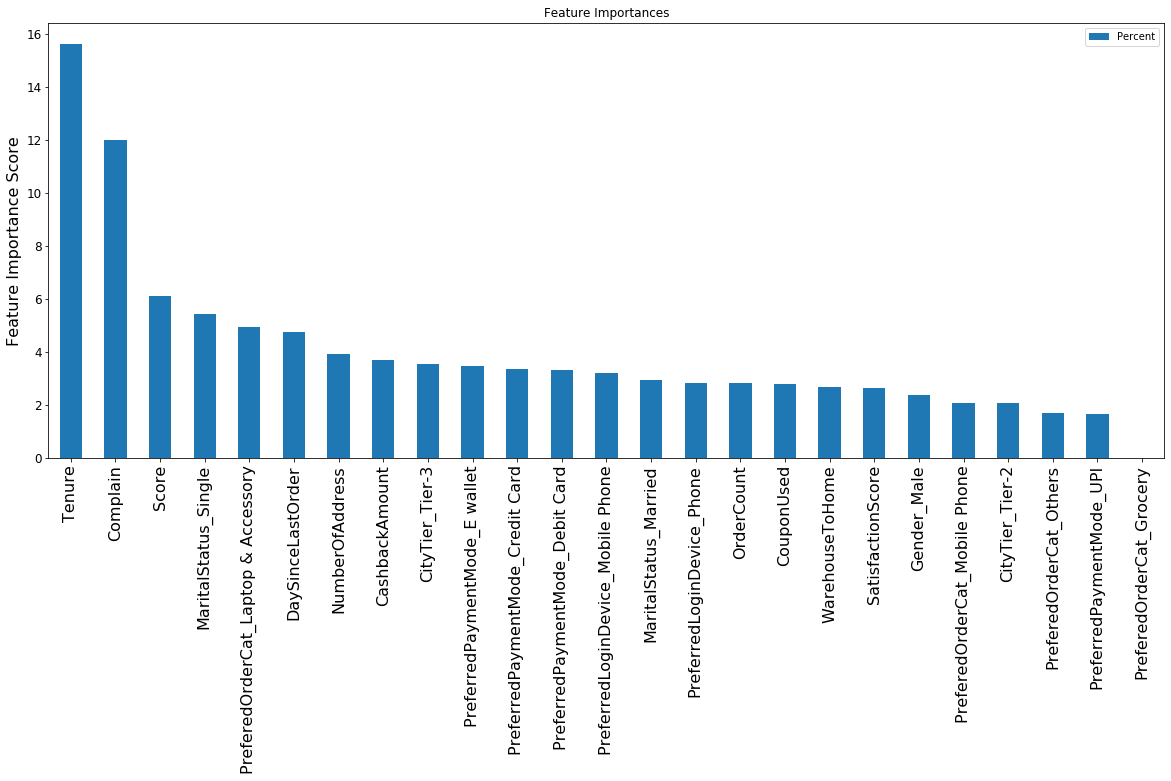

In [43]:
feature_importance=pd.DataFrame((XGB_model.feature_importances_*100).round(2),index=X_train.columns,columns=['Percent']).sort_values('Percent',ascending=False)
feature_importance.plot(kind='bar', title='Feature Importances',figsize=(20,8),fontsize=12)
plt.ylabel('Feature Importance Score',fontsize=16)
plt.xticks(fontsize=16)

Train data Performance metrics


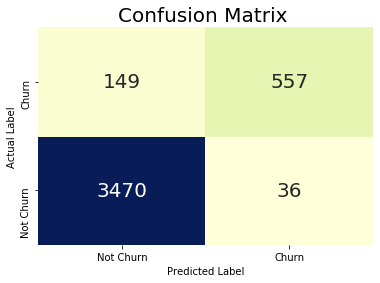

Classification report
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3506
           1       0.94      0.79      0.86       706

    accuracy                           0.96      4212
   macro avg       0.95      0.89      0.92      4212
weighted avg       0.96      0.96      0.95      4212

Accuracy : 95.61 %
Precision :  93.93 %
Recall / True Positive Rate :  78.9 %
Specificity / True Negative Rate :  98.97 %
ROC AUC Score: 98.8 %


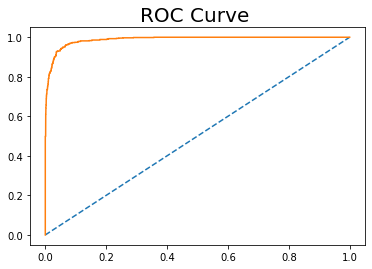

Test data Performance metrics


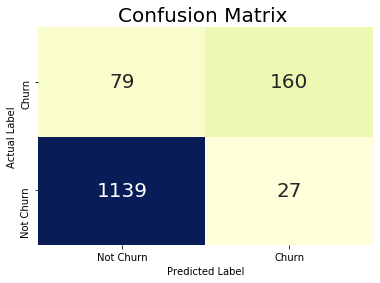

Classification report
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1166
           1       0.86      0.67      0.75       239

    accuracy                           0.92      1405
   macro avg       0.90      0.82      0.85      1405
weighted avg       0.92      0.92      0.92      1405

Accuracy : 92.46 %
Precision :  85.56 %
Recall / True Positive Rate :  66.95 %
Specificity / True Negative Rate :  97.68 %
ROC AUC Score: 95.7 %


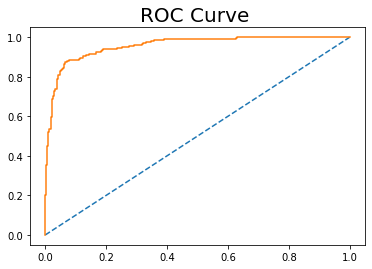

In [45]:
x=['Tenure', 'WarehouseToHome', 'SatisfactionScore', 'NumberOfAddress',#'NumberOfDeviceRegistered',
       'Complain', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount', 'Score',
       'PreferredLoginDevice_Mobile Phone', 'PreferredLoginDevice_Phone',
       'CityTier_Tier-2', 'CityTier_Tier-3',
       'PreferredPaymentMode_Credit Card', 'PreferredPaymentMode_Debit Card',
       'PreferredPaymentMode_E wallet', 'PreferredPaymentMode_UPI',
       'Gender_Male', 'PreferedOrderCat_Grocery',
       'PreferedOrderCat_Laptop & Accessory', 'PreferedOrderCat_Mobile Phone',
       'PreferedOrderCat_Others', 'MaritalStatus_Married',
       'MaritalStatus_Single']
XGB_model=xgb.XGBClassifier(random_state=1,max_depth=6,colsample_bytree=0.5,gamma=4)
XGB_model.fit(X_train[x], y_train)
print('Train data Performance metrics')
train_score,train_precision,train_recall=cal_performance_metrics(XGB_model,X_train[x],y_train)
print('Test data Performance metrics')
test_score,test_precision,test_recall=cal_performance_metrics(XGB_model,X_test[x],y_test)
temp_accuracyDF=pd.DataFrame({'Train Score':train_score,'Test Score':test_score,'Train Precision':train_precision,'Test Precision':test_precision,'Train Recall':train_recall,'Test Recall':test_recall},index=['XGBoost_Tuned_Final'])
model_accuracyDF=pd.concat([model_accuracyDF,temp_accuracyDF])

### KNN Classifier

Train data Performance metrics


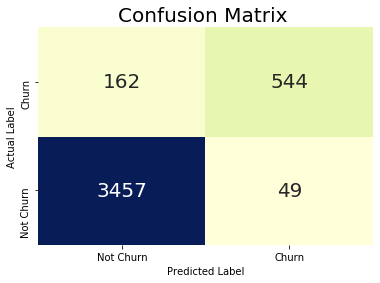

Classification report
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3506
           1       0.92      0.77      0.84       706

    accuracy                           0.95      4212
   macro avg       0.94      0.88      0.90      4212
weighted avg       0.95      0.95      0.95      4212

Accuracy : 94.99 %
Precision :  91.74 %
Recall / True Positive Rate :  77.05 %
Specificity / True Negative Rate :  98.6 %
ROC AUC Score: 98.6 %


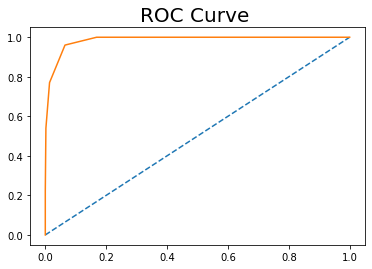

Test data Performance metrics


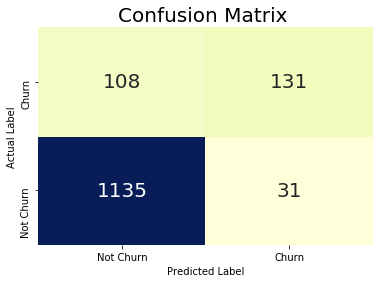

Classification report
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1166
           1       0.81      0.55      0.65       239

    accuracy                           0.90      1405
   macro avg       0.86      0.76      0.80      1405
weighted avg       0.90      0.90      0.89      1405

Accuracy : 90.11 %
Precision :  80.86 %
Recall / True Positive Rate :  54.81 %
Specificity / True Negative Rate :  97.34 %
ROC AUC Score: 94.4 %


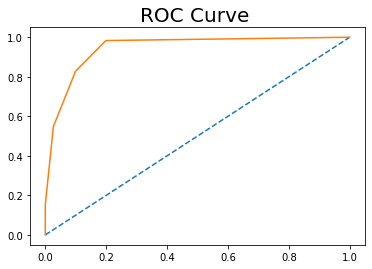

In [46]:
from sklearn.neighbors import KNeighborsClassifier

KNN_model=KNeighborsClassifier()
KNN_model.fit(X_train_scaled,y_train)
print('Train data Performance metrics')
train_score,train_precision,train_recall=cal_performance_metrics(KNN_model,X_train_scaled,y_train)
print('Test data Performance metrics')
test_score,test_precision,test_recall=cal_performance_metrics(KNN_model,X_test_scaled,y_test)
temp_accuracyDF=pd.DataFrame({'Train Score':train_score,'Test Score':test_score,'Train Precision':train_precision,'Test Precision':test_precision,'Train Recall':train_recall,'Test Recall':test_recall},index=['KNN'])
model_accuracyDF=pd.concat([model_accuracyDF,temp_accuracyDF])

Train data Performance metrics


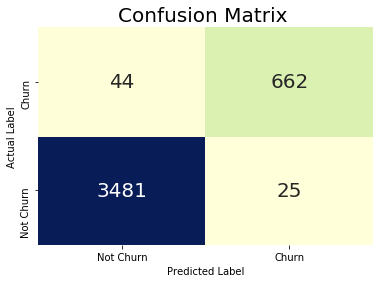

Classification report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3506
           1       0.96      0.94      0.95       706

    accuracy                           0.98      4212
   macro avg       0.98      0.97      0.97      4212
weighted avg       0.98      0.98      0.98      4212

Accuracy : 98.36 %
Precision :  96.36 %
Recall / True Positive Rate :  93.77 %
Specificity / True Negative Rate :  99.29 %
ROC AUC Score: 99.7 %


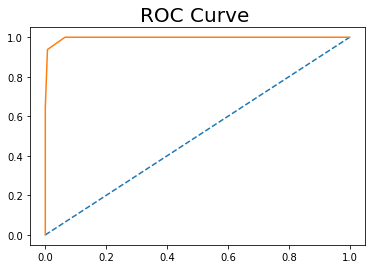

Test data Performance metrics


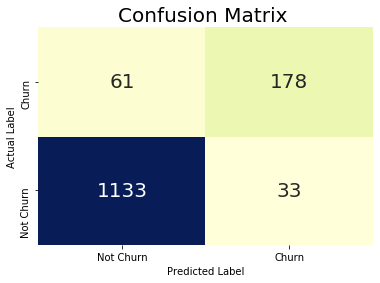

Classification report
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1166
           1       0.84      0.74      0.79       239

    accuracy                           0.93      1405
   macro avg       0.90      0.86      0.88      1405
weighted avg       0.93      0.93      0.93      1405

Accuracy : 93.31 %
Precision :  84.36 %
Recall / True Positive Rate :  74.48 %
Specificity / True Negative Rate :  97.17 %
ROC AUC Score: 96.6 %


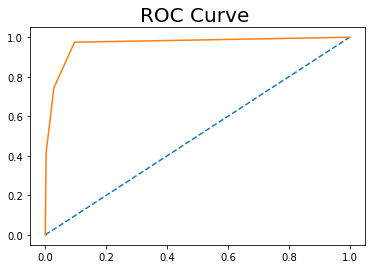

In [47]:
KNN_model=KNeighborsClassifier(n_neighbors=3)
KNN_model.fit(X_train_scaled,y_train)
print('Train data Performance metrics')
train_score,train_precision,train_recall=cal_performance_metrics(KNN_model,X_train_scaled,y_train)
print('Test data Performance metrics')
test_score,test_precision,test_recall=cal_performance_metrics(KNN_model,X_test_scaled,y_test)
temp_accuracyDF=pd.DataFrame({'Train Score':train_score,'Test Score':test_score,'Train Precision':train_precision,'Test Precision':test_precision,'Train Recall':train_recall,'Test Recall':test_recall},index=['KNN_Tuned'])
model_accuracyDF=pd.concat([model_accuracyDF,temp_accuracyDF])

In [48]:
#KNN recall is very low for 1. Not tuning it further

### Decision Tree

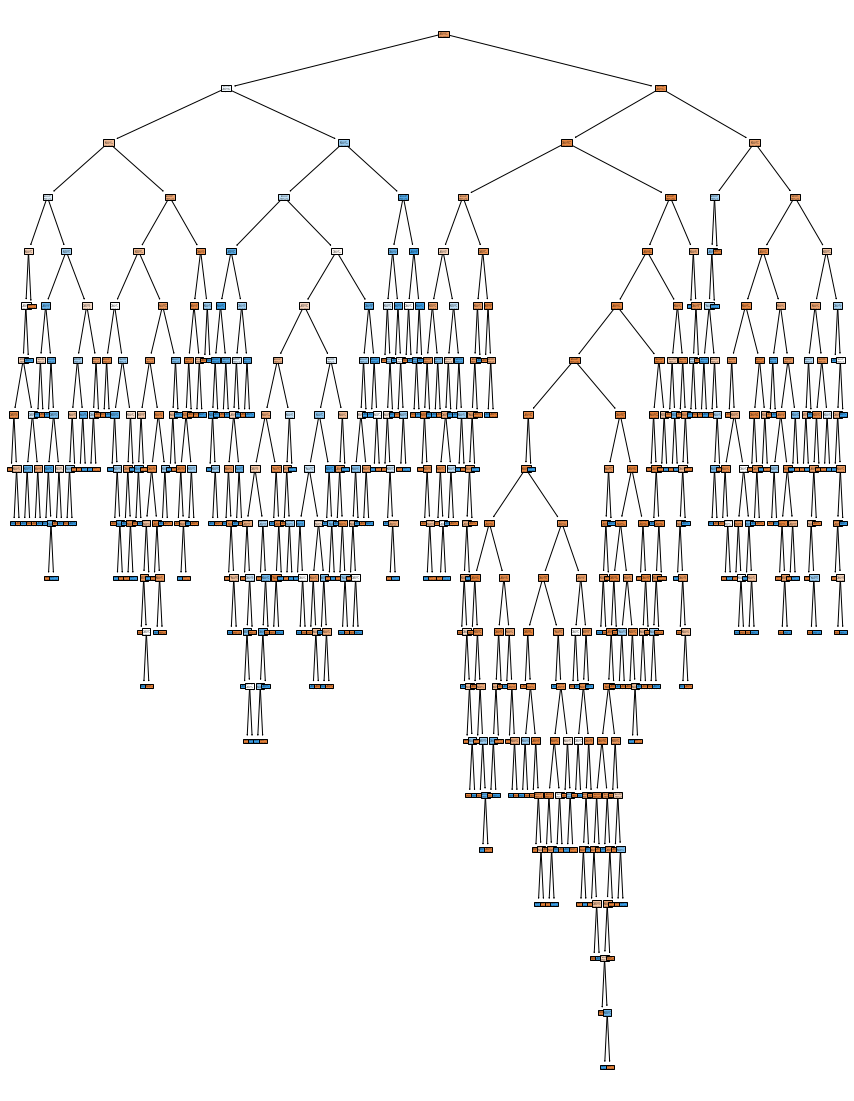

In [49]:
from sklearn import tree
DT_model= tree.DecisionTreeClassifier()
plt.figure(figsize=(15,20))
tree.plot_tree(DT_model.fit(X_train, y_train),filled=True) 
plt.show()

Train data Performance metrics


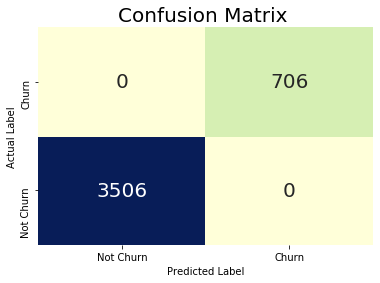

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3506
           1       1.00      1.00      1.00       706

    accuracy                           1.00      4212
   macro avg       1.00      1.00      1.00      4212
weighted avg       1.00      1.00      1.00      4212

Accuracy : 100.0 %
Precision :  100.0 %
Recall / True Positive Rate :  100.0 %
Specificity / True Negative Rate :  100.0 %
ROC AUC Score: 100.0 %


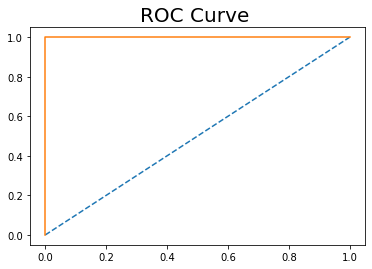

Test data Performance metrics


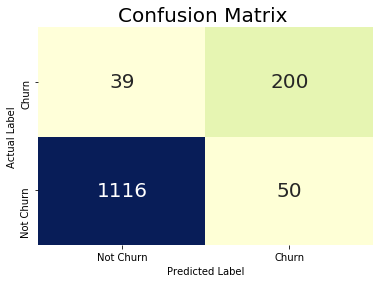

Classification report
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1166
           1       0.80      0.84      0.82       239

    accuracy                           0.94      1405
   macro avg       0.88      0.90      0.89      1405
weighted avg       0.94      0.94      0.94      1405

Accuracy : 93.67 %
Precision :  80.0 %
Recall / True Positive Rate :  83.68 %
Specificity / True Negative Rate :  95.71 %
ROC AUC Score: 89.7 %


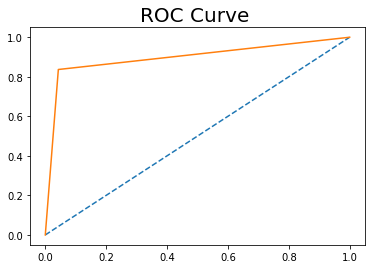

In [50]:
print('Train data Performance metrics')
train_score,train_precision,train_recall=cal_performance_metrics(DT_model,X_train,y_train)
print('Test data Performance metrics')
test_score,test_precision,test_recall=cal_performance_metrics(DT_model,X_test,y_test)
temp_accuracyDF=pd.DataFrame({'Train Score':train_score,'Test Score':test_score,'Train Precision':train_precision,'Test Precision':test_precision,'Train Recall':train_recall,'Test Recall':test_recall},index=['Decision Tree'])
model_accuracyDF=pd.concat([model_accuracyDF,temp_accuracyDF])

Text(0, 0.5, 'Feature Importance Score')

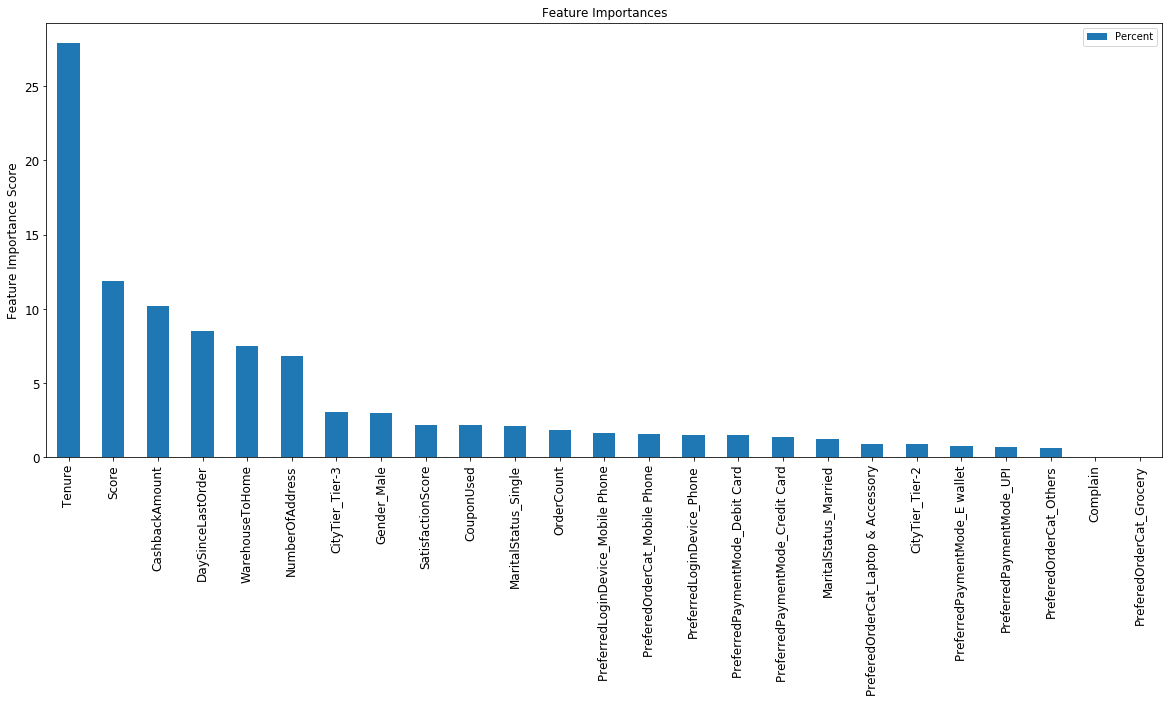

In [51]:
feature_importance=pd.DataFrame((DT_model.feature_importances_*100).round(2),index=X_train.columns,columns=['Percent']).sort_values('Percent',ascending=False)
feature_importance.plot(kind='bar', title='Feature Importances',figsize=(20,8),fontsize=12)
plt.ylabel('Feature Importance Score',fontsize=12)

In [52]:
feature_importance[feature_importance.Percent>2].index

Index(['Tenure', 'Score', 'CashbackAmount', 'DaySinceLastOrder',
       'WarehouseToHome', 'NumberOfAddress', 'CityTier_Tier-3', 'Gender_Male',
       'SatisfactionScore', 'CouponUsed', 'MaritalStatus_Single'],
      dtype='object')

param_grid={   'min_samples_split' : [10,5], #30,40,50 #between 0.5 to 1% (2%?)
               'min_samples_leaf' : [3,5,2,],#2,10
               'max_depth' : [15],#5,10,12
                'criterion' :['gini','entropy']
               }
grid_search=GridSearchCV(DecisionTreeClassifier(),param_grid=param_grid,n_jobs=-1,cv=7,verbose=True,scoring=['precision','recall'],refit=False)
grid_search.fit(X_train, y_train)
#min_sample_leaf =10,min_sample_split=30
grid_search.cv_results_

Train data Performance metrics


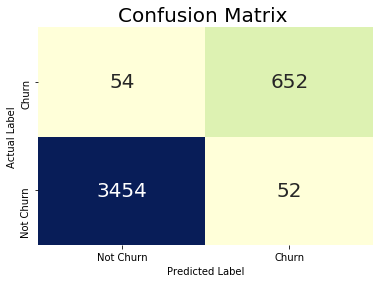

Classification report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3506
           1       0.93      0.92      0.92       706

    accuracy                           0.97      4212
   macro avg       0.96      0.95      0.95      4212
weighted avg       0.97      0.97      0.97      4212

Accuracy : 97.48 %
Precision :  92.61 %
Recall / True Positive Rate :  92.35 %
Specificity / True Negative Rate :  98.52 %
ROC AUC Score: 99.7 %


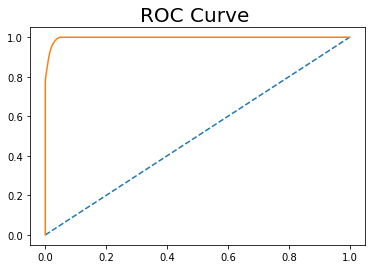

Test data Performance metrics


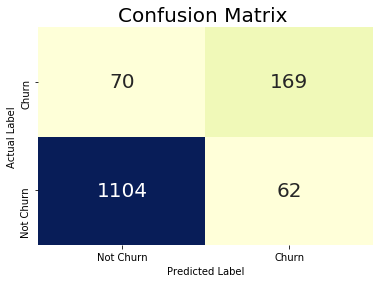

Classification report
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1166
           1       0.73      0.71      0.72       239

    accuracy                           0.91      1405
   macro avg       0.84      0.83      0.83      1405
weighted avg       0.90      0.91      0.91      1405

Accuracy : 90.6 %
Precision :  73.16 %
Recall / True Positive Rate :  70.71 %
Specificity / True Negative Rate :  94.68 %
ROC AUC Score: 90.5 %


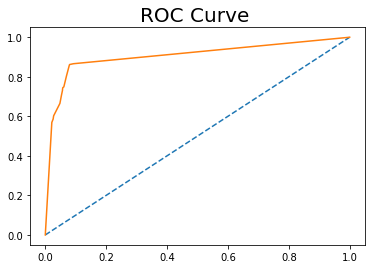

In [53]:
dt_model=DecisionTreeClassifier(criterion='entropy',max_depth=15,min_samples_leaf=3,min_samples_split=5)
dt_model.fit(X_train,y_train)
print('Train data Performance metrics')
train_score,train_precision,train_recall=cal_performance_metrics(dt_model,X_train,y_train)
print('Test data Performance metrics')
test_score,test_precision,test_recall=cal_performance_metrics(dt_model,X_test,y_test)
#Overfitting

Train data Performance metrics


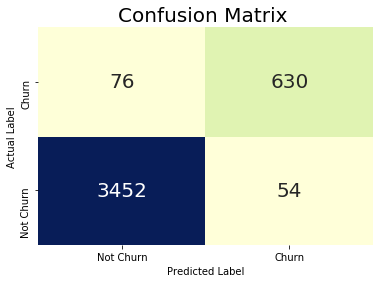

Classification report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3506
           1       0.92      0.89      0.91       706

    accuracy                           0.97      4212
   macro avg       0.95      0.94      0.94      4212
weighted avg       0.97      0.97      0.97      4212

Accuracy : 96.91 %
Precision :  92.11 %
Recall / True Positive Rate :  89.24 %
Specificity / True Negative Rate :  98.46 %
ROC AUC Score: 99.5 %


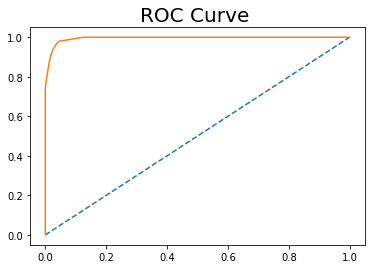

Test data Performance metrics


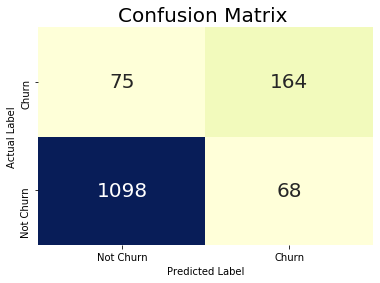

Classification report
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1166
           1       0.71      0.69      0.70       239

    accuracy                           0.90      1405
   macro avg       0.82      0.81      0.82      1405
weighted avg       0.90      0.90      0.90      1405

Accuracy : 89.82 %
Precision :  70.69 %
Recall / True Positive Rate :  68.62 %
Specificity / True Negative Rate :  94.17 %
ROC AUC Score: 91.5 %


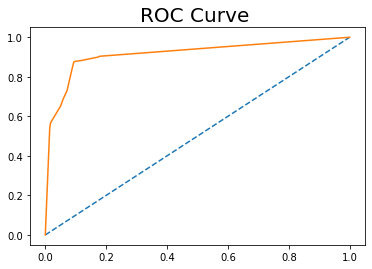

In [54]:
dt_model=DecisionTreeClassifier(criterion='gini',max_depth=12,min_samples_leaf=3,min_samples_split=5)
dt_model.fit(X_train,y_train)
print('Train data Performance metrics')
train_score,train_precision,train_recall=cal_performance_metrics(dt_model,X_train,y_train)
print('Test data Performance metrics')
test_score,test_precision,test_recall=cal_performance_metrics(dt_model,X_test,y_test)
temp_accuracyDF=pd.DataFrame({'Train Score':train_score,'Test Score':test_score,'Train Precision':train_precision,'Test Precision':test_precision,'Train Recall':train_recall,'Test Recall':test_recall},index=['Decision Tree Tuned'])
model_accuracyDF=pd.concat([model_accuracyDF,temp_accuracyDF])

### Randon Forest Classifier

In [55]:
RF_model=RandomForestClassifier(n_estimators=100,random_state=1)
RF_model.fit(X_train, y_train)
feature_importance=pd.DataFrame((DT_model.feature_importances_*100).round(2),index=X_train.columns,columns=['Percent']).sort_values('Percent',ascending=False)
#cross_val_score(RF_model,X_train, y_train,cv=5,scoring='precision')

In [56]:
col_DT=['Tenure', 'CashbackAmount', 'Score', 'WarehouseToHome',
       'DaySinceLastOrder', 'NumberOfAddress', #'OrderAmountHikeFromlastYear','NumberOfDeviceRegistered'
       'Complain', 'SatisfactionScore',
       'OrderCount', 'CouponUsed', 
       'MaritalStatus_Single', 'PreferedOrderCat_Mobile Phone',
       'MaritalStatus_Married', 'Gender_Male',
       'PreferedOrderCat_Laptop & Accessory',
       'PreferredLoginDevice_Mobile Phone', 'PreferredPaymentMode_Debit Card',
       'PreferredPaymentMode_Credit Card', 
       'PreferredLoginDevice_Phone', 'PreferredPaymentMode_E wallet',
       'PreferredPaymentMode_UPI', 'PreferedOrderCat_Others','CityTier_Tier-2','CityTier_Tier-3',
       'PreferedOrderCat_Grocery']#'Complain','SatisfactionScore','DaySinceLastOrder','WarehouseToHome',' CouponUsed', 

In [57]:
RF_model=RandomForestClassifier(n_estimators=100,random_state=1)
RF_model.fit(X_train[col_DT], y_train)
#cross_val_score(RF_model,X_train[col_DT], y_train,cv=5,scoring='precision')

RandomForestClassifier(random_state=1)

Train data Performance metrics


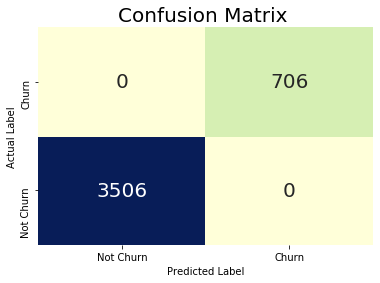

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3506
           1       1.00      1.00      1.00       706

    accuracy                           1.00      4212
   macro avg       1.00      1.00      1.00      4212
weighted avg       1.00      1.00      1.00      4212

Accuracy : 100.0 %
Precision :  100.0 %
Recall / True Positive Rate :  100.0 %
Specificity / True Negative Rate :  100.0 %
ROC AUC Score: 100.0 %


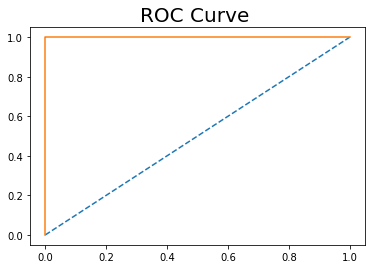

Test data Performance metrics


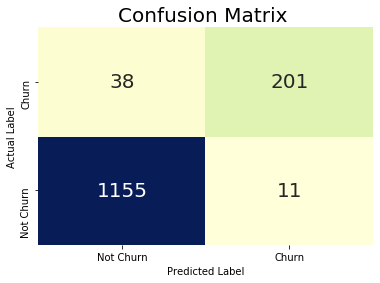

Classification report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1166
           1       0.95      0.84      0.89       239

    accuracy                           0.97      1405
   macro avg       0.96      0.92      0.94      1405
weighted avg       0.96      0.97      0.96      1405

Accuracy : 96.51 %
Precision :  94.81 %
Recall / True Positive Rate :  84.1 %
Specificity / True Negative Rate :  99.06 %
ROC AUC Score: 98.8 %


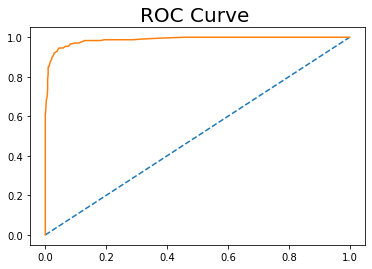

In [58]:
print('Train data Performance metrics')
train_score,train_precision,train_recall=cal_performance_metrics(RF_model,X_train[col_DT],y_train)
print('Test data Performance metrics')
test_score,test_precision,test_recall=cal_performance_metrics(RF_model,X_test[col_DT],y_test)
temp_accuracyDF=pd.DataFrame({'Train Score':train_score,'Test Score':test_score,'Train Precision':train_precision,'Test Precision':test_precision,'Train Recall':train_recall,'Test Recall':test_recall},index=['Random Forest'])
model_accuracyDF=pd.concat([model_accuracyDF,temp_accuracyDF])

param_grid_GB={'n_estimators' : [200],#
               'min_samples_split' : [2], #20,30,40,50 #between 0.5 to 1% (2%?) ,3,5,7,10
               'min_samples_leaf' : [2],#3,5,10,20,25
               'max_depth' : [12],#14,15,7,10,
               'max_features':[5]
               }
grid_search=GridSearchCV(RandomForestClassifier(),param_grid=param_grid_GB,n_jobs=-1,cv=3,verbose=True,scoring=['precision','recall'],refit=False)
grid_search.fit(X_train[col_DT], y_train)


Train data Performance metrics


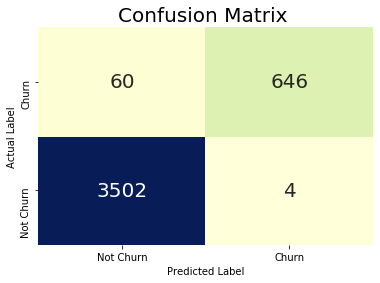

Classification report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3506
           1       0.99      0.92      0.95       706

    accuracy                           0.98      4212
   macro avg       0.99      0.96      0.97      4212
weighted avg       0.98      0.98      0.98      4212

Accuracy : 98.48 %
Precision :  99.38 %
Recall / True Positive Rate :  91.5 %
Specificity / True Negative Rate :  99.89 %
ROC AUC Score: 99.9 %


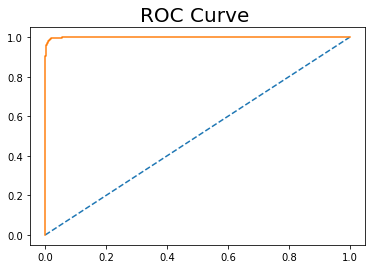

Test data Performance metrics


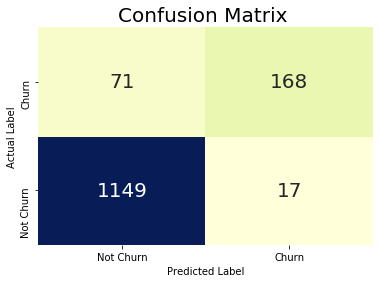

Classification report
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1166
           1       0.91      0.70      0.79       239

    accuracy                           0.94      1405
   macro avg       0.92      0.84      0.88      1405
weighted avg       0.94      0.94      0.93      1405

Accuracy : 93.74 %
Precision :  90.81 %
Recall / True Positive Rate :  70.29 %
Specificity / True Negative Rate :  98.54 %
ROC AUC Score: 97.7 %


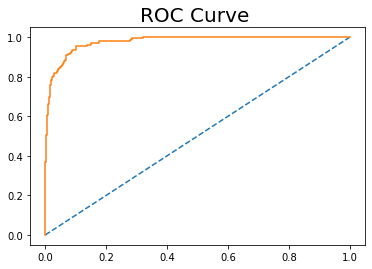

In [59]:
grid_rf=RandomForestClassifier(n_estimators=200,min_samples_split=2,min_samples_leaf=2,max_depth=12,max_features=5)
grid_rf.fit(X_train[col_DT],y_train)
print('Train data Performance metrics')
train_score,train_precision,train_recall=cal_performance_metrics(grid_rf,X_train[col_DT],y_train)
print('Test data Performance metrics')
test_score,test_precision,test_recall=cal_performance_metrics(grid_rf,X_test[col_DT],y_test)
temp_accuracyDF=pd.DataFrame({'Train Score':train_score,'Test Score':test_score,'Train Precision':train_precision,'Test Precision':test_precision,'Train Recall':train_recall,'Test Recall':test_recall},index=['Random Forest Tuned'])
model_accuracyDF=pd.concat([model_accuracyDF,temp_accuracyDF])

Text(0, 0.5, 'Feature Importance Score')

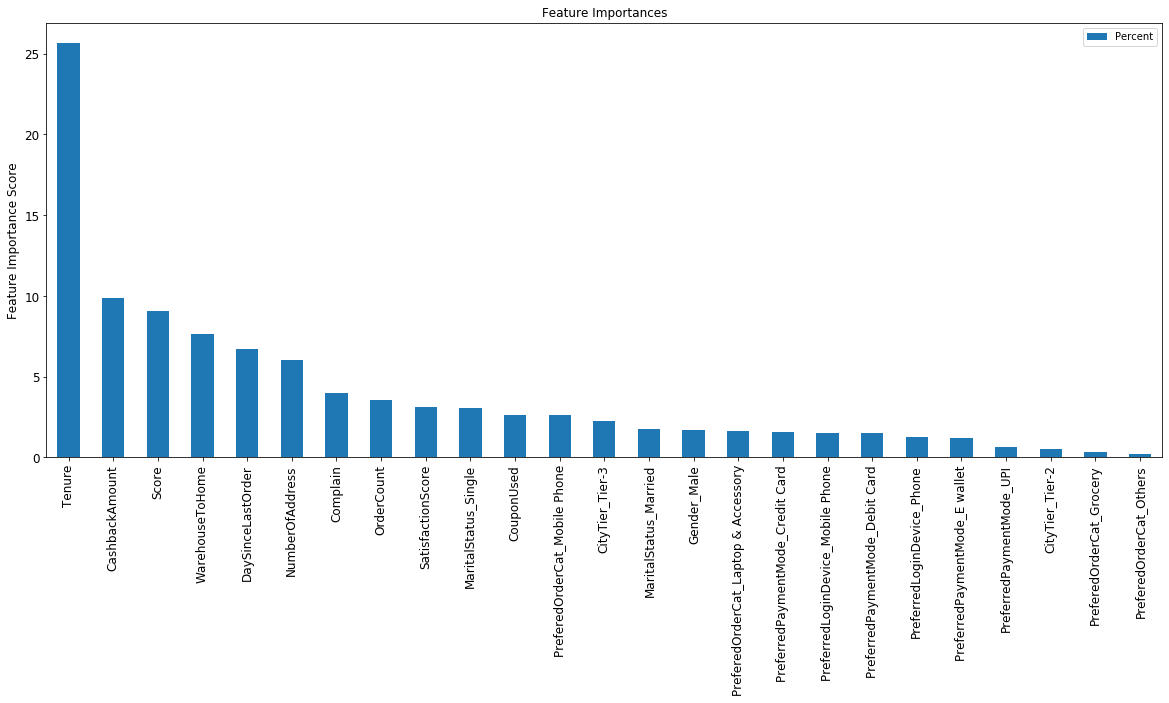

In [60]:
feature_importance=pd.DataFrame((grid_rf.feature_importances_*100).round(2),index=X_train[col_DT].columns,columns=['Percent']).sort_values('Percent',ascending=False)
feature_importance.plot(kind='bar', title='Feature Importances',figsize=(20,8),fontsize=12)
plt.ylabel('Feature Importance Score',fontsize=12)

### Bagging Classifier

Train data Performance metrics


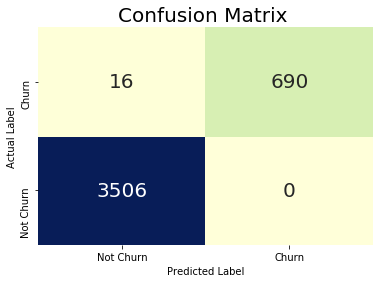

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3506
           1       1.00      0.98      0.99       706

    accuracy                           1.00      4212
   macro avg       1.00      0.99      0.99      4212
weighted avg       1.00      1.00      1.00      4212

Accuracy : 99.62 %
Precision :  100.0 %
Recall / True Positive Rate :  97.73 %
Specificity / True Negative Rate :  100.0 %
ROC AUC Score: 100.0 %


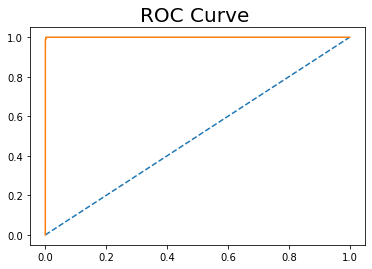

Test data Performance metrics


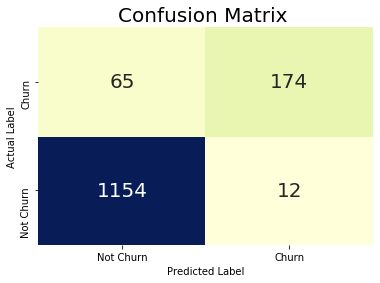

Classification report
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1166
           1       0.94      0.73      0.82       239

    accuracy                           0.95      1405
   macro avg       0.94      0.86      0.89      1405
weighted avg       0.94      0.95      0.94      1405

Accuracy : 94.52 %
Precision :  93.55 %
Recall / True Positive Rate :  72.8 %
Specificity / True Negative Rate :  98.97 %
ROC AUC Score: 98.2 %


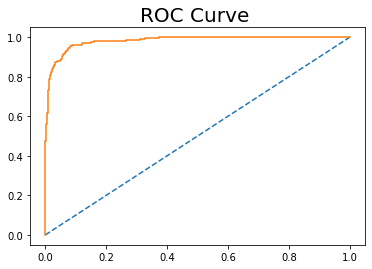

In [61]:
rf = RandomForestClassifier()
Bagging_model=BaggingClassifier(base_estimator=rf,n_estimators=80,random_state=1)
Bagging_model.fit(X_train, y_train)
print('Train data Performance metrics')
train_score,train_precision,train_recall=cal_performance_metrics(Bagging_model,X_train,y_train)
print('Test data Performance metrics')
test_score,test_precision,test_recall=cal_performance_metrics(Bagging_model,X_test,y_test)
temp_accuracyDF=pd.DataFrame({'Train Score':train_score,'Test Score':test_score,'Train Precision':train_precision,'Test Precision':test_precision,'Train Recall':train_recall,'Test Recall':test_recall},index=['Bagging RF'])
model_accuracyDF=pd.concat([model_accuracyDF,temp_accuracyDF])

Train data Performance metrics


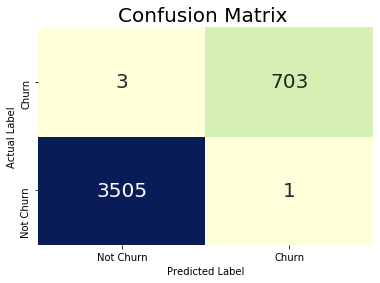

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3506
           1       1.00      1.00      1.00       706

    accuracy                           1.00      4212
   macro avg       1.00      1.00      1.00      4212
weighted avg       1.00      1.00      1.00      4212

Accuracy : 99.91 %
Precision :  99.86 %
Recall / True Positive Rate :  99.58 %
Specificity / True Negative Rate :  99.97 %
ROC AUC Score: 100.0 %


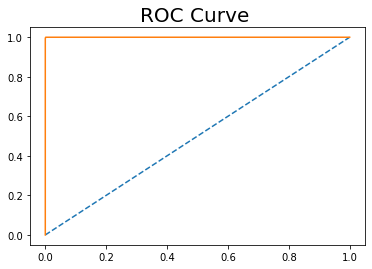

Test data Performance metrics


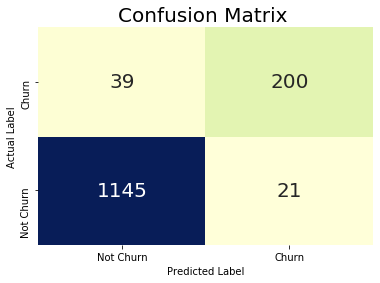

Classification report
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1166
           1       0.90      0.84      0.87       239

    accuracy                           0.96      1405
   macro avg       0.94      0.91      0.92      1405
weighted avg       0.96      0.96      0.96      1405

Accuracy : 95.73 %
Precision :  90.5 %
Recall / True Positive Rate :  83.68 %
Specificity / True Negative Rate :  98.2 %
ROC AUC Score: 97.9 %


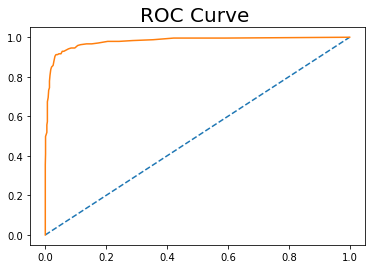

In [62]:
cart = DecisionTreeClassifier()
Bagging_model=BaggingClassifier(base_estimator=cart,n_estimators=50,max_samples=0.8,random_state=1)
Bagging_model.fit(X_train, y_train)
print('Train data Performance metrics')
train_score,train_precision,train_recall=cal_performance_metrics(Bagging_model,X_train,y_train)
print('Test data Performance metrics')
test_score,test_precision,test_recall=cal_performance_metrics(Bagging_model,X_test,y_test)
temp_accuracyDF=pd.DataFrame({'Train Score':train_score,'Test Score':test_score,'Train Precision':train_precision,'Test Precision':test_precision,'Train Recall':train_recall,'Test Recall':test_recall},index=['Bagging CART'])
model_accuracyDF=pd.concat([model_accuracyDF,temp_accuracyDF])

### Logistic Regression

In [63]:
X=data_cc.drop(['CustomerID','Churn'],axis=1)
y=data_cc.Churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25 , random_state=1)

In [64]:
from sklearn.linear_model import LogisticRegression
logistic_model=LogisticRegression()
logistic_model.fit(X_train_scaled, y_train)
print(logistic_model.score(X_train_scaled, y_train))
print(logistic_model.score(X_test_scaled, y_test))
#Recall 0.5 bombed

0.8910256410256411
0.8761565836298932


In [65]:
import statsmodels.api as sm
logit_mod = sm.Logit(y_train,X_train)
result = logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.270053
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4212
Model:                          Logit   Df Residuals:                     4184
Method:                           MLE   Df Model:                           27
Date:                Sun, 20 Dec 2020   Pseudo R-squ.:                  0.4027
Time:                        06:59:56   Log-Likelihood:                -1137.5
converged:                       True   LL-Null:                       -1904.2
Covariance Type:            nonrobust   LLR p-value:                7.035e-307
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Tenure                                 -0.2156      0.012    -18.494      0.000      -0.238      -0.193
WarehouseToHome                         0.0384      0.007      5.739      0.000       0.025       0.052
HourSpendOnApp                         -0.0830      0.092     -0.907      0.364      -0.262       0.096
NumberOfDeviceRegistered                0.3630      0.063      5.786      0.000       0.240       0.486
SatisfactionScore                       0.3001      0.064      4.691      0.000       0.175       0.425
NumberOfAddress                         0.2490      0.023     11.042      0.000       0.205       0.293
Complain                                1.8288      0.280      6.530      0.000       1.280       2.378
OrderAmountHikeFromlastYear            -0.0045      0.015     -0.305      0.761      -0.033       0.024
CouponUsed                              0.0261      0.044      0.598      0.550      -0.059       0.111
OrderCount                              0.1579      0.030      5.329      0.000       0.100       0.216
DaySinceLastOrder                      -0.1320      0.022     -5.986      0.000      -0.175      -0.089
CashbackAmount                         -0.0208      0.002     -8.957      0.000      -0.025      -0.016
Score                                   0.0003      0.016      0.017      0.986      -0.032       0.032
PreferredLoginDevice_Mobile Phone      -0.5354      0.134     -4.007      0.000      -0.797      -0.273
PreferredLoginDevice_Phone             -0.6308      0.147     -4.304      0.000      -0.918      -0.344
CityTier_Tier-2                         1.0745      0.273      3.930      0.000       0.539       1.610
CityTier_Tier-3                         0.7355      0.140      5.245      0.000       0.461       1.010
PreferredPaymentMode_Credit Card       -0.6750      0.190     -3.560      0.000      -1.047      -0.303
PreferredPaymentMode_Debit Card        -0.4247      0.182     -2.329      0.020      -0.782      -0.067
PreferredPaymentMode_E wallet           0.1005      0.241      0.418      0.676      -0.371       0.572
PreferredPaymentMode_UPI               -0.8968      0.261     -3.435      0.001      -1.409      -0.385
Gender_Male                             0.3721      0.112      3.311      0.001       0.152       0.592
PreferedOrderCat_Grocery                0.8612      0.411      2.097      0.036       0.056       1.666
PreferedOrderCat_Laptop & Accessory    -1.8506      0.192     -9.624      0.000      -2.227      -1.474
PreferedOrderCat_Mobile Phone          -0.9578      0.208     -4.607      0.000      -1.365      -0.550
PreferedOrderCat_Others                 3.1819      0.456      6.972      0.000       2.287       4.076
MaritalStatus_Married                  -0.3068      0.159     -1.934      0.053      -0.618       0.004
MaritalStatus_Single                    0.8002      0.159      5.033      0.000       0.489       1.112
=================

In [66]:
#HourSpendOnApp,CouponUsed,PreferredPaymentMode_Credit Card,PreferredPaymentMode_Debit Card,
#PreferredPaymentMode_UPI,Score are insignificant variables
import statsmodels.api as sm
logit_mod = sm.Logit(y_train,X_train.drop(['PreferredPaymentMode_UPI','PreferredPaymentMode_Credit Card','CouponUsed','Score','HourSpendOnApp','PreferredPaymentMode_Debit Card'],axis=1))
result = logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.272244
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4212
Model:                          Logit   Df Residuals:                     4190
Method:                           MLE   Df Model:                           21
Date:                Sun, 20 Dec 2020   Pseudo R-squ.:                  0.3978
Time:                        06:59:56   Log-Likelihood:                -1146.7
converged:                       True   LL-Null:                       -1904.2
Covariance Type:            nonrobust   LLR p-value:                2.130e-308
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Tenure                                 -0.2170      0.012    -18.715      0.000      -0.240      -0.194
WarehouseToHome                         0.0362      0.007      5.450      0.000       0.023       0.049
NumberOfDeviceRegistered                0.3557      0.060      5.891      0.000       0.237       0.474
SatisfactionScore                       0.2939      0.040      7.273      0.000       0.215       0.373
NumberOfAddress                         0.2424      0.022     10.909      0.000       0.199       0.286
Complain                                1.8150      0.113     15.999      0.000       1.593       2.037
OrderAmountHikeFromlastYear            -0.0084      0.014     -0.581      0.561      -0.037       0.020
OrderCount                              0.1703      0.024      7.184      0.000       0.124       0.217
DaySinceLastOrder                      -0.1338      0.022     -6.134      0.000      -0.177      -0.091
CashbackAmount                         -0.0230      0.002    -11.331      0.000      -0.027      -0.019
PreferredLoginDevice_Mobile Phone      -0.5259      0.132     -3.972      0.000      -0.785      -0.266
PreferredLoginDevice_Phone             -0.6409      0.145     -4.418      0.000      -0.925      -0.357
CityTier_Tier-2                         0.9187      0.259      3.544      0.000       0.411       1.427
CityTier_Tier-3                         0.7403      0.139      5.345      0.000       0.469       1.012
PreferredPaymentMode_E wallet           0.5871      0.187      3.146      0.002       0.221       0.953
Gender_Male                             0.3590      0.111      3.227      0.001       0.141       0.577
PreferedOrderCat_Grocery                0.9123      0.405      2.252      0.024       0.118       1.706
PreferedOrderCat_Laptop & Accessory    -1.9846      0.184    -10.785      0.000      -2.345      -1.624
PreferedOrderCat_Mobile Phone          -1.1396      0.185     -6.162      0.000      -1.502      -0.777
PreferedOrderCat_Others                 3.3790      0.435      7.771      0.000       2.527       4.231
MaritalStatus_Married                  -0.3645      0.156     -2.330      0.020      -0.671      -0.058
MaritalStatus_Single                    0.7659      0.156      4.899      0.000       0.459       1.072
=======================================================================================================
"""

In [67]:
X_vif=X_train.copy()
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)
calc_vif(X_train[cont]).sort_values(by='VIF', ascending = False)

,variables,VIF
6,CashbackAmount,10.307161
4,OrderCount,4.034904
2,NumberOfAddress,3.908813
1,WarehouseToHome,3.875679
5,DaySinceLastOrder,3.460520
3,CouponUsed,3.337729
0,Tenure,3.210101


In [68]:
import statsmodels.api as sm
logit_mod = sm.Logit(y_train,X_train.drop(['CashbackAmount','HourSpendOnApp','NumberOfDeviceRegistered','OrderAmountHikeFromlastYear'],axis=1))
result = logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.284276
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4212
Model:                          Logit   Df Residuals:                     4188
Method:                           MLE   Df Model:                           23
Date:                Sun, 20 Dec 2020   Pseudo R-squ.:                  0.3712
Time:                        06:59:56   Log-Likelihood:                -1197.4
converged:                       True   LL-Null:                       -1904.2
Covariance Type:            nonrobust   LLR p-value:                7.617e-285
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Tenure                                 -0.2272      0.012    -19.706      0.000      -0.250      -0.205
WarehouseToHome                         0.0202      0.006      3.223      0.001       0.008       0.032
SatisfactionScore                       0.0682      0.055      1.231      0.218      -0.040       0.177
NumberOfAddress                         0.1911      0.021      8.990      0.000       0.149       0.233
Complain                                1.1078      0.256      4.321      0.000       0.605       1.610
CouponUsed                             -0.0141      0.042     -0.332      0.740      -0.097       0.069
OrderCount                              0.1344      0.029      4.648      0.000       0.078       0.191
DaySinceLastOrder                      -0.1645      0.021     -7.679      0.000      -0.207      -0.123
Score                                   0.0367      0.015      2.417      0.016       0.007       0.067
PreferredLoginDevice_Mobile Phone      -0.7979      0.125     -6.396      0.000      -1.042      -0.553
PreferredLoginDevice_Phone             -0.6533      0.142     -4.587      0.000      -0.932      -0.374
CityTier_Tier-2                         0.8934      0.273      3.269      0.001       0.358       1.429
CityTier_Tier-3                         0.5671      0.136      4.173      0.000       0.301       0.833
PreferredPaymentMode_Credit Card       -1.2524      0.171     -7.313      0.000      -1.588      -0.917
PreferredPaymentMode_Debit Card        -0.9860      0.161     -6.131      0.000      -1.301      -0.671
PreferredPaymentMode_E wallet          -0.4750      0.223     -2.128      0.033      -0.913      -0.038
PreferredPaymentMode_UPI               -1.3091      0.244     -5.372      0.000      -1.787      -0.832
Gender_Male                             0.1725      0.106      1.622      0.105      -0.036       0.381
PreferedOrderCat_Grocery               -0.3764      0.382     -0.985      0.325      -1.126       0.373
PreferedOrderCat_Laptop & Accessory    -1.4619      0.165     -8.872      0.000      -1.785      -1.139
PreferedOrderCat_Mobile Phone          -0.3724      0.154     -2.418      0.016      -0.674      -0.071
PreferedOrderCat_Others                 0.9822      0.367      2.674      0.008       0.262       1.702
MaritalStatus_Married                  -0.6649      0.145     -4.598      0.000      -0.948      -0.381
MaritalStatus_Single                    0.4304      0.144      2.987      0.003       0.148       0.713
=======================================================================================================
"""

In [69]:
data_logit_train=X_train.drop(['CashbackAmount','HourSpendOnApp','NumberOfDeviceRegistered','OrderAmountHikeFromlastYear','CouponUsed','PreferedOrderCat_Grocery','SatisfactionScore','Gender_Male','PreferredPaymentMode_E wallet','MaritalStatus_Single'],axis=1)
data_logit_test=X_test.drop(['CashbackAmount','HourSpendOnApp','NumberOfDeviceRegistered','OrderAmountHikeFromlastYear','CouponUsed','PreferedOrderCat_Grocery','SatisfactionScore','Gender_Male','PreferredPaymentMode_E wallet','MaritalStatus_Single'],axis=1)
logit_mod = sm.Logit(y_train,data_logit_train)
result = logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.286499
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4212
Model:                          Logit   Df Residuals:                     4194
Method:                           MLE   Df Model:                           17
Date:                Sun, 20 Dec 2020   Pseudo R-squ.:                  0.3663
Time:                        06:59:56   Log-Likelihood:                -1206.7
converged:                       True   LL-Null:                       -1904.2
Covariance Type:            nonrobust   LLR p-value:                1.922e-286
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Tenure                                 -0.2257      0.011    -20.036      0.000      -0.248      -0.204
WarehouseToHome                         0.0233      0.006      3.902      0.000       0.012       0.035
NumberOfAddress                         0.1969      0.021      9.590      0.000       0.157       0.237
Complain                                0.9034      0.186      4.860      0.000       0.539       1.268
OrderCount                              0.1275      0.022      5.787      0.000       0.084       0.171
DaySinceLastOrder                      -0.1548      0.021     -7.486      0.000      -0.195      -0.114
Score                                   0.0494      0.010      4.940      0.000       0.030       0.069
PreferredLoginDevice_Mobile Phone      -0.7628      0.123     -6.225      0.000      -1.003      -0.523
PreferredLoginDevice_Phone             -0.6149      0.140     -4.377      0.000      -0.890      -0.340
CityTier_Tier-2                         0.8804      0.274      3.218      0.001       0.344       1.417
CityTier_Tier-3                         0.5373      0.120      4.461      0.000       0.301       0.773
PreferredPaymentMode_Credit Card       -0.9769      0.146     -6.696      0.000      -1.263      -0.691
PreferredPaymentMode_Debit Card        -0.6971      0.131     -5.332      0.000      -0.953      -0.441
PreferredPaymentMode_UPI               -1.0026      0.224     -4.476      0.000      -1.442      -0.564
PreferedOrderCat_Laptop & Accessory    -1.3404      0.155     -8.656      0.000      -1.644      -1.037
PreferedOrderCat_Mobile Phone          -0.1635      0.133     -1.232      0.218      -0.424       0.097
PreferedOrderCat_Others                 1.0891      0.360      3.027      0.002       0.384       1.794
MaritalStatus_Married                  -0.9389      0.106     -8.870      0.000      -1.146      -0.731
=======================================================================================================
"""

In [70]:
y_prob_pred_train = result.predict(data_logit_train)
y_prob_pred_test = result.predict(data_logit_test)
y_class_pred=[]
for i in range(0,len(y_prob_pred_train)):
    if np.array(y_prob_pred_train)[i]>0.5:
        a=1
    else:
        a=0
    y_class_pred.append(a)
y_test_pred=[]
for i in range(0,len(y_prob_pred_test)):
    if np.array(y_prob_pred_test)[i]>0.5:
        a=1
    else:
        a=0
    y_test_pred.append(a)

(0, 2)

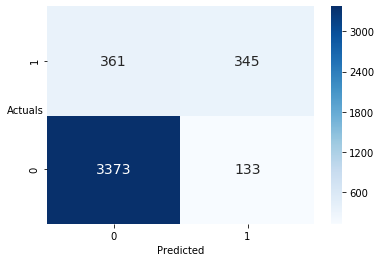

In [71]:
fig, ax = plt.subplots()
sns.heatmap((metrics.confusion_matrix(y_train,y_class_pred)),annot=True,fmt='.5g',cmap='Blues',annot_kws={"size": 14});
plt.xlabel('Predicted');
plt.ylabel('Actuals',rotation=0);
ax.set_ylim([0,2])


In [72]:
def calculate_metrics(y,y_pred):
    cm1 = metrics.confusion_matrix(y,y_pred)
    print(cm1)
    total1=sum(sum(cm1))
    
    #####from confusion matrix calculate accuracy
    accuracy1=(((cm1[0,0]+cm1[1,1])/total1)*100).round(2)
    print ('Accuracy : ', accuracy1)

    precision=cm1[1,1]/(cm1[1,1]+cm1[0,1]) # Of all 1's predicted, how many were predicted right.
    precision=(precision*100).round(2)
    print('Precision : ',precision,'%') #False positive , alpha Type 1 error
    
    sensitivity1 = (cm1[1,1]/(cm1[1,1]+cm1[1,0]))*100
    print('Sensitivity / Recall / True Positive Rate : ', sensitivity1.round(2)) # How many actual true data points are identified by model
#Type2 Error
    specificity1 = (cm1[0,0]/(cm1[0,1]+cm1[0,0]))*100
    print('Specificity : ', specificity1.round(2)) # How many negative points identified by model
    
    print(metrics.classification_report(y,y_pred,digits=3))
    
    return accuracy1,precision,sensitivity1.round(2)
    
    
print('Train data Performance metrics')
train_score,train_precision,train_recall=calculate_metrics(y_train,y_class_pred)
print('Test data Performance metrics')
test_score,test_precision,test_recall=calculate_metrics(y_test,y_test_pred)

Train data Performance metrics
[[3373  133]
 [ 361  345]]
Accuracy :  88.27
Precision :  72.18 %
Sensitivity / Recall / True Positive Rate :  48.87
Specificity :  96.21
              precision    recall  f1-score   support

           0      0.903     0.962     0.932      3506
           1      0.722     0.489     0.583       706

    accuracy                          0.883      4212
   macro avg      0.813     0.725     0.757      4212
weighted avg      0.873     0.883     0.873      4212

Test data Performance metrics
[[1111   55]
 [ 120  119]]
Accuracy :  87.54
Precision :  68.39 %
Sensitivity / Recall / True Positive Rate :  49.79
Specificity :  95.28
              precision    recall  f1-score   support

           0      0.903     0.953     0.927      1166
           1      0.684     0.498     0.576       239

    accuracy                          0.875      1405
   macro avg      0.793     0.725     0.752      1405
weighted avg      0.865     0.875     0.867      1405



In [73]:
fpr, tpr, thresholds = roc_curve(y_train,y_prob_pred_train)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.26053604289211685

In [74]:
y_class_pred=[]
for i in range(0,len(y_prob_pred_train)):
    if np.array(y_prob_pred_train)[i]>optimal_threshold:
        a=1
    else:
        a=0
    y_class_pred.append(a)
train_score,train_precision,train_recall=calculate_metrics(y_train,y_class_pred)

y_test_pred=[]
for i in range(0,len(y_prob_pred_test)):
    if np.array(y_prob_pred_test)[i]>optimal_threshold:
        a=1
    else:
        a=0
    y_test_pred.append(a)
test_score,test_precision,test_recall=calculate_metrics(y_test,y_test_pred)
temp_accuracyDF=pd.DataFrame({'Train Score':train_score,'Test Score':test_score,'Train Precision':train_precision,'Test Precision':test_precision,'Train Recall':train_recall,'Test Recall':test_recall},index=['Logistic regression'])
model_accuracyDF=pd.concat([model_accuracyDF,temp_accuracyDF])

[[3110  396]
 [ 187  519]]
Accuracy :  86.16
Precision :  56.72 %
Sensitivity / Recall / True Positive Rate :  73.51
Specificity :  88.71
              precision    recall  f1-score   support

           0      0.943     0.887     0.914      3506
           1      0.567     0.735     0.640       706

    accuracy                          0.862      4212
   macro avg      0.755     0.811     0.777      4212
weighted avg      0.880     0.862     0.868      4212

[[1028  138]
 [  71  168]]
Accuracy :  85.12
Precision :  54.9 %
Sensitivity / Recall / True Positive Rate :  70.29
Specificity :  88.16
              precision    recall  f1-score   support

           0      0.935     0.882     0.908      1166
           1      0.549     0.703     0.617       239

    accuracy                          0.851      1405
   macro avg      0.742     0.792     0.762      1405
weighted avg      0.870     0.851     0.858      1405



In [75]:
coef_summary = pd.DataFrame(result.params,columns=['Coef'])
coef_summary

,Coef
Tenure,-0.225733
WarehouseToHome,0.023335
NumberOfAddress,0.196876
Complain,0.903418
OrderCount,0.127488
DaySinceLastOrder,-0.154796
Score,0.049384
PreferredLoginDevice_Mobile Phone,-0.762828
PreferredLoginDevice_Phone,-0.614920
CityTier_Tier-2,0.880414


In [76]:
# Interpreting the Coefficients
coef_summary['Odds'] = np.exp(coef_summary['Coef'])
coef_summary['Prob'] = (coef_summary['Odds'])/(coef_summary['Odds']+1)
coef_summary

,Coef,Odds,Prob
Tenure,-0.225733,0.797931,0.443805
WarehouseToHome,0.023335,1.023609,0.505833
NumberOfAddress,0.196876,1.217593,0.549061
Complain,0.903418,2.468024,0.711651
OrderCount,0.127488,1.135971,0.531829
DaySinceLastOrder,-0.154796,0.856590,0.461378
Score,0.049384,1.050624,0.512344
PreferredLoginDevice_Mobile Phone,-0.762828,0.466346,0.318033
PreferredLoginDevice_Phone,-0.614920,0.540684,0.350938
CityTier_Tier-2,0.880414,2.411897,0.706908


We can interpret the above model using the probability coefficients for example if a customer is in a tier-3 city the probability for churning increases by 63%, also for every unit increase in the cashback amount the probability reduces by 49.7% etc.

In [77]:
model_accuracyDF.sort_values('Test Recall',ascending=False)

,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
MLP Tuned 2,100.00,96.87,100.00,90.46,100.00,91.21
Random Forest,100.00,96.51,100.00,94.81,100.00,84.10
Bagging CART,99.91,95.73,99.86,90.50,99.58,83.68
Decision Tree,100.00,93.67,100.00,80.00,100.00,83.68
AdaBoost Tuned,97.67,94.45,96.91,88.89,88.95,76.99
MLP,97.96,93.52,97.55,84.58,90.08,75.73
KNN_Tuned,98.36,93.31,96.36,84.36,93.77,74.48
Bagging RF,99.62,94.52,100.00,93.55,97.73,72.80
Random Forest Tuned,98.48,93.74,99.38,90.81,91.50,70.29
Logistic regression,86.16,85.12,56.72,54.90,73.51,70.29


In [78]:
model_accuracyDF.sort_values('Test Precision',ascending=False)

,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
Random Forest,100.00,96.51,100.00,94.81,100.00,84.10
Bagging RF,99.62,94.52,100.00,93.55,97.73,72.80
Random Forest Tuned,98.48,93.74,99.38,90.81,91.50,70.29
Bagging CART,99.91,95.73,99.86,90.50,99.58,83.68
MLP Tuned 2,100.00,96.87,100.00,90.46,100.00,91.21
SVM,92.90,91.03,93.02,90.07,62.32,53.14
AdaBoost Tuned,97.67,94.45,96.91,88.89,88.95,76.99
SVM_Tuned,94.30,91.89,93.96,86.98,70.54,61.51
XGBoost_Tuned_Final,95.61,92.46,93.93,85.56,78.90,66.95
MLP,97.96,93.52,97.55,84.58,90.08,75.73


In [79]:
model_accuracyDF.sort_index()

,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
AdaBoost,90.08,89.25,75.81,72.45,59.92,59.41
AdaBoost Tuned,97.67,94.45,96.91,88.89,88.95,76.99
Bagging CART,99.91,95.73,99.86,90.50,99.58,83.68
Bagging RF,99.62,94.52,100.00,93.55,97.73,72.80
Decision Tree,100.00,93.67,100.00,80.00,100.00,83.68
Decision Tree Tuned,96.91,89.82,92.11,70.69,89.24,68.62
Gradient Boosting,93.21,90.96,89.33,80.43,67.56,61.92
Gradient Boosting Tuned,95.23,91.89,92.01,80.49,78.33,69.04
KNN,94.99,90.11,91.74,80.86,77.05,54.81
KNN_Tuned,98.36,93.31,96.36,84.36,93.77,74.48
